# Example: Static inverse free-boundary equilibrium calculations (in ITER)

---

Here we will generate an equilibrium (find coil currents with the inverse solver) in an ITER-like tokamak. 

The machine description comes from files located [here](https://github.com/ProjectTorreyPines/FUSE.jl).

The equilbirium\profile parameters are **completely made up** - please experiment on your own and change them to more realistic values as you please!

### Import packages

In [1]:
import os
import matplotlib.pyplot as plt
import freegs4e
import numpy as np

### Create the machine object

In [2]:
# set paths
os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/ITER/ITER_active_coils.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/ITER/ITER_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/ITER/ITER_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/ITER/ITER_limiter.pickle"

In [3]:
# Now the machine can actually be built:
from freegsnke import build_machine
tokamak = build_machine.tokamak()

No coil named Solenoid among the active coils.
No probe configuration is provided


Text(60.291666666666664, 0.5, 'Height, $Z$ [m]')

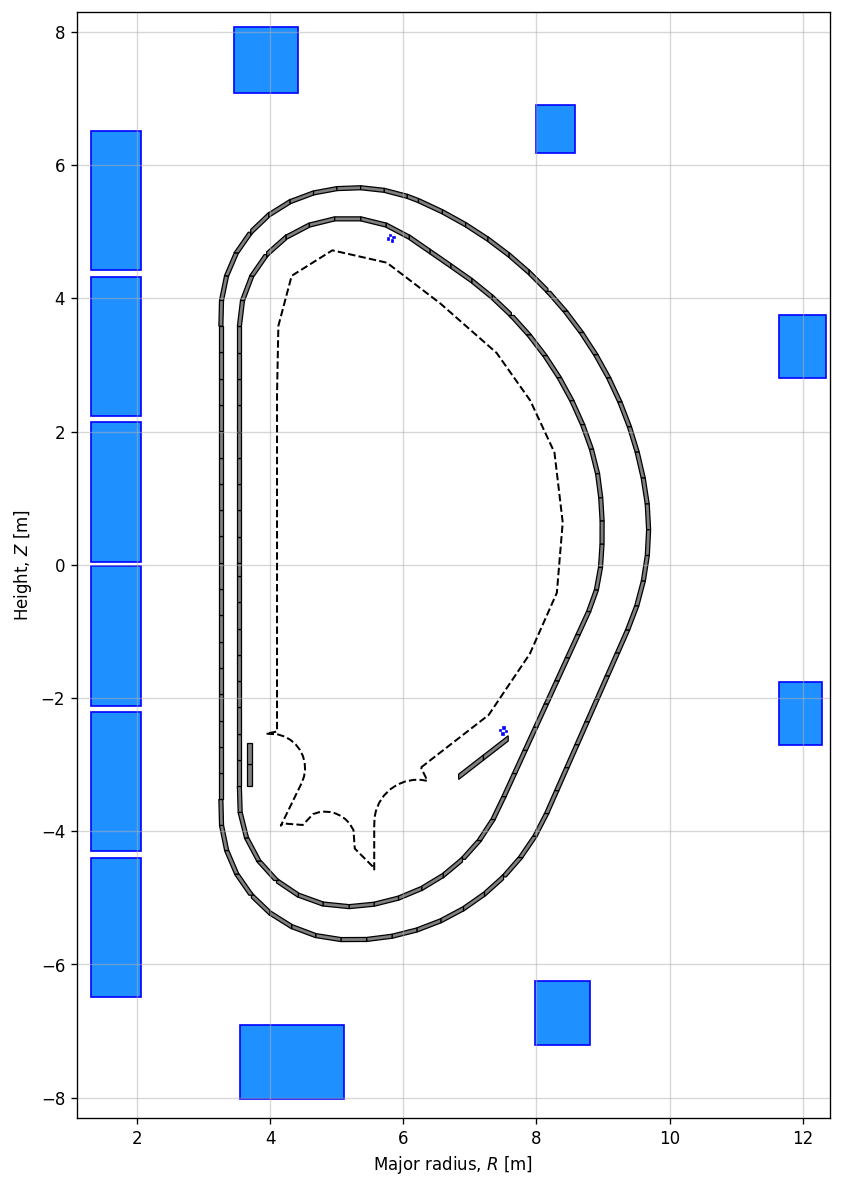

In [4]:
# plot the machine
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 15), dpi=120)
plt.tight_layout()

tokamak.plot(axis=ax1, show=False)
ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
# ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(1.1, 12.4)
ax1.set_ylim(-8.3, 8.3)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')

### Instantiate an equilibrium

In [5]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,       # provide tokamak object
    Rmin=2.6, Rmax=10,   # radial range
    Zmin=-6, Zmax=6,   # vertical range
    nx=129,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,                # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

### Instantiate a profile object

In [6]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(
    eq=eq,        # equilibrium object
    betap=0.1,   # poloidal beta
    Ip=11e6,      # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=2.0,  # profile function parameter
    alpha_n=1.0   # profile function parameter
)

### Load the static nonlinear solver

In [7]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Constraints

In [8]:
Rx = 4.93      # X-point radius
Zx = -3.36      # X-point height

# set desired null_points locations
# this can include X-point and O-point locations
null_points = [[Rx], [Zx]]

# set desired isoflux constraints with format 
# isoflux_set = [isoflux_0, isoflux_1 ... ] 
# with each isoflux_i = [R_coords, Z_coords]
isoflux_set = np.array([[[Rx, 4.22, 4.35, 7.26, 7.91, 8.14, 7.47, 6.05, 4.85, 4.28], [Zx, 0.55, -1.45, -1.94, -0.77, 0.55, 2.55, 3.74, 3.78, 2.50]]])
           
# instantiate the freegsnke constrain object
from freegsnke.inverse import Inverse_optimizer
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)



### The inverse solve

In [9]:
# re-normalise the plasma flux -- default peak is 1
eq.plasma_psi *= 20

GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     max_solving_iterations=500,
                     verbose=True, # print output
                     l2_reg=np.array([1e-7]*10), 
                     )

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:650: RuntimeWarning: divide by zero encountered in scalar divide
  rel_delta_psit /= np.linalg.norm(self.tokamak_psi)
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:979: RuntimeWarning: invalid value encountered in scalar multiply
  previous_rel_delta_psit = rel_delta_psit * adj_factor


The initial coil currents and initial plasma_psi are significantly mismatched!
Please ensure that sufficient isoflux constraints are provided (for example, try providing at least three non-aligned points on the LCFS).
Initial setup of the currents triggered. Relative update of tokamak_psi in the core of: inf
Current updates: [-2787653.08019634   616716.68723382  1230917.99614073   -70970.07208926
  2098301.2968328   -399843.44453272  -343217.03524279   -49638.52137685
  -169968.66134302   246809.25042576]
---
---
Iteration 0 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: nan
Current updates: [-0.  0.  0. -0.  0. -0. -0. -0. -0.  0.]
Magnetic constraint losses = 0.8667469253934429
Handing off to forward_solve. Requested tolerance: nan
Forward static solve complete. Last relative residual: 1.245747511607458
 
Iteration 1 complete.
---
Iteration 1 starting...
Using Greens' Jacobian to optimise.
Control currents upda

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 1.2027965050438851.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.2072760807257697e-05 with less than 1 iterations. Last relative psi change: 1.1568169181804413.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.8075988812770072e-05 with less than 1 iterations. Last relative psi change: 1.1077883825069355.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 

Iteration 5 complete.
---
Iteration 5 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.011459426533865936
Current updates: [ 1.99898450e+01  1.24402405e+01  5.96781090e-01 -1.69391451e+03
 -1.57815732e+01 -1.32699426e+02 -2.81188712e+02 -3.04507873e+02
 -1.21712487e+02 -2.56738662e+01]
Magnetic constraint losses = 6.381124052805088
Handing off to forward_solve. Requested tolerance: 2.263590426442654e-05
Iteration 6 complete.
---
Iteration 6 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.013630125476226926
Current updates: [ 2.45734214e+01  1.48679649e+01  5.03245190e-01 -2.03576922e+03
 -1.93624233e+01 -1.59798587e+02 -3.38988602e+02 -3.66959895e+02
 -1.46503352e+02 -3.09474267e+01]
Magnetic constraint losses = 7.832524186244143
Handing off to forward_solve. Requested tolerance: 1.7949136429599243e-05
Iteration 7 complete.
---
Iteration 7

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.7949136429599243e-05 with less than 1 iterations. Last relative psi change: 0.9454750456035493.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.3663578740859782e-05 with less than 1 iterations. Last relative psi change: 0.8861146113491679.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 9.759461687485977e-06 with less than 1 iterations. Last relative psi change: 0.824437875476419.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relativ

Iteration 10 complete.
---
Iteration 10 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.016014627014995914
Current updates: [ 3.16951866e+01  1.83870809e+01  2.44664857e-01 -2.53160921e+03
 -2.47632943e+01 -1.99888478e+02 -4.26149283e+02 -4.60916749e+02
 -1.83409014e+02 -3.88276784e+01]
Magnetic constraint losses = 13.487451797023567
Handing off to forward_solve. Requested tolerance: 4.165772002071792e-06
Iteration 11 complete.
---
Iteration 11 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.015694334474696
Current updates: [ 3.16149947e+01  1.82802991e+01  2.19452425e-01 -2.51784488e+03
 -2.46237226e+01 -1.98793274e+02 -4.24482937e+02 -4.59227976e+02
 -1.82685877e+02 -3.86891598e+01]
Magnetic constraint losses = 14.943128886863732
Handing off to forward_solve. Requested tolerance: 2.721637708020238e-06
Iteration 12 complete.
---
Iteratio

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 2.721637708020238e-06 with less than 1 iterations. Last relative psi change: 0.6282371450030259.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.7781366359065548e-06 with less than 1 iterations. Last relative psi change: 0.5600502415586804.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1.1617159354589493e-06 with less than 1 iterations. Last relative psi change: 0.4908594150931933.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relati

Iteration 15 complete.
---
Iteration 15 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.014475954411849911
Current updates: [ 3.08711852e+01  1.78452059e+01  2.47902995e-01 -2.45738440e+03
 -2.36841076e+01 -1.93390317e+02 -4.15887418e+02 -4.50798315e+02
 -1.79328138e+02 -3.80287177e+01]
Magnetic constraint losses = 20.45521434331889
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 16 complete.
---
Iteration 16 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.014186435323612915
Current updates: [ 3.07002115e+01  1.77631119e+01  2.60754618e-01 -2.44073787e+03
 -2.35662015e+01 -1.92632240e+02 -4.14291077e+02 -4.48726537e+02
 -1.78330984e+02 -3.78027508e+01]
Magnetic constraint losses = 20.43867053729735
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 17 complete.
---
Iteration 17 starting...
Using Greens' 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.45825395514110834.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4576302014829365.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4570075375884707.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 19 complete.
---
Iteration 19 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.013352159435101886
Current updates: [ 3.01547899e+01  1.74958041e+01  2.97116179e-01 -2.38793875e+03
 -2.31950185e+01 -1.90152754e+02 -4.09002079e+02 -4.41947536e+02
 -1.75112736e+02 -3.70758161e+01]
Magnetic constraint losses = 20.293960887059974
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 20 complete.
---
Iteration 20 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.013085116246399848
Current updates: [ 2.99610136e+01  1.73993624e+01  3.08779677e-01 -2.36945909e+03
 -2.30618548e+01 -1.89243680e+02 -4.07060097e+02 -4.39502031e+02
 -1.73970274e+02 -3.68190674e+01]
Magnetic constraint losses = 20.24434652220656
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 21 complete.
---
Iteration 21 starting...
Using Greens'

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.45576372930508513.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.45482122006115844.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4542007340480957.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 22 complete.
---
Iteration 22 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.012566945643042412
Current updates: [ 2.95558478e+01  1.71957278e+01  3.31472436e-01 -2.33130586e+03
 -2.27802675e+01 -1.87298566e+02 -4.02909246e+02 -4.34343500e+02
 -1.71588771e+02 -3.62860070e+01]
Magnetic constraint losses = 20.156447185160218
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 23 complete.
---
Iteration 23 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.012315606730181563
Current updates: [ 2.93455988e+01  1.70890733e+01  3.42411201e-01 -2.31167041e+03
 -2.26335713e+01 -1.86271708e+02 -4.00714451e+02 -4.31640923e+02
 -1.70352325e+02 -3.60100471e+01]
Magnetic constraint losses = 20.109275102971296
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 24 complete.
---
Iteration 24 starting...
Using Greens

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.45233819145606263.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.45171774003534937.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4510973189075043.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 27 complete.
---
Iteration 27 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.011359523519001186
Current updates: [ 2.84564839e+01  1.66320091e+01  3.83527660e-01 -2.22987874e+03
 -2.20065781e+01 -1.81807876e+02 -3.91170113e+02 -4.20064761e+02
 -1.65132974e+02 -3.48508874e+01]
Magnetic constraint losses = 19.92896030184303
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 28 complete.
---
Iteration 28 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.011132333048621162
Current updates: [ 2.82232899e+01  1.65107252e+01  3.93113335e-01 -2.20871658e+03
 -2.18405864e+01 -1.80608832e+02 -3.88605608e+02 -4.16994275e+02
 -1.63766253e+02 -3.45486933e+01]
Magnetic constraint losses = 19.886009213487966
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 29 complete.
---
Iteration 29 starting...
Using Greens'

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4500961073251567.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.44947429178825865.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.44885118818956965.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Control currents updated. Relative update of tokamak_psi in the core of: 0.010477662806697848
Current updates: [ 2.75016848e+01  1.61322578e+01  4.20088904e-01 -2.14381783e+03
 -2.13242484e+01 -1.76838568e+02 -3.80535723e+02 -4.07413181e+02
 -1.59538505e+02 -3.36166891e+01]
Magnetic constraint losses = 19.755557916939626
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 32 complete.
---
Iteration 32 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.01026810955056389
Current updates: [ 2.72540901e+01  1.60014048e+01  4.28495547e-01 -2.12177721e+03
 -2.11457209e+01 -1.75523668e+02 -3.77722328e+02 -4.04102344e+02
 -1.58090624e+02 -3.32985313e+01]
Magnetic constraint losses = 19.71607257836945
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 33 complete.
---
Iteration 33 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the co

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.44721905278828394.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4465929538182812.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4428650569817423.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 36 complete.
---
Iteration 36 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.009470977312832042
Current updates: [ 2.62357409e+01  1.54584517e+01  4.59026644e-01 -2.03203617e+03
 -2.04070338e+01 -1.70023720e+02 -3.65947492e+02 -3.90366291e+02
 -1.52139340e+02 -3.19950988e+01]
Magnetic constraint losses = 19.560063300638944
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 37 complete.
---
Iteration 37 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.009281557766575401
Current updates: [ 2.59652682e+01  1.53131673e+01  4.66099908e-01 -2.00933642e+03
 -2.01989486e+01 -1.68490247e+02 -3.62723298e+02 -3.86724896e+02
 -1.50607715e+02 -3.16638552e+01]
Magnetic constraint losses = 19.6131167191472
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 38 complete.
---
Iteration 38 starting...
Using Greens' 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4191268624466956.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.41850362239468647.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4178787374731134.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 41 complete.
---
Iteration 41 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.008561013359089861
Current updates: [ 2.48326662e+01  1.46998050e+01  4.90953587e-01 -1.91792800e+03
 -1.92932377e+01 -1.61825882e+02 -3.48854737e+02 -3.71437633e+02
 -1.44332559e+02 -3.03207687e+01]
Magnetic constraint losses = 20.113878881743084
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 42 complete.
---
Iteration 42 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.008389793091908064
Current updates: [ 2.45625588e+01  1.45520464e+01  4.95854526e-01 -1.89487745e+03
 -1.90935241e+01 -1.60293070e+02 -3.45569213e+02 -3.67701480e+02
 -1.42758581e+02 -2.99795393e+01]
Magnetic constraint losses = 20.083837891668868
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 43 complete.
---
Iteration 43 starting...
Using Greens

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4171086134741495.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4167206000447035.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.41633041942802573.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 45 complete.
---
Iteration 45 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.007896406139759133
Current updates: [ 2.37484699e+01  1.41043918e+01  5.08699994e-01 -1.82564076e+03
 -1.84917062e+01 -1.55639786e+02 -3.35579778e+02 -3.56376775e+02
 -1.38006280e+02 -2.89506447e+01]
Magnetic constraint losses = 19.977436858317006
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 46 complete.
---
Iteration 46 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.007738478016963952
Current updates: [ 2.34756003e+01  1.39536234e+01  5.12392491e-01 -1.80257918e+03
 -1.82892215e+01 -1.54065732e+02 -3.32200287e+02 -3.52563265e+02
 -1.36414370e+02 -2.86066706e+01]
Magnetic constraint losses = 19.943659228632278
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 47 complete.
---
Iteration 47 starting...
Using Greens

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.415543347444145.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.41532884253353197.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4149286241373111.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 49 complete.
---
Iteration 49 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.007283393601742334
Current updates: [ 2.26552495e+01  1.34982720e+01  5.21735660e-01 -1.73360735e+03
 -1.76789186e+01 -1.49295339e+02 -3.21953625e+02 -3.41045558e+02
 -1.31628348e+02 -2.75742837e+01]
Magnetic constraint losses = 19.84193191969839
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 50 complete.
---
Iteration 50 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.007137725729707487
Current updates: [ 2.23812754e+01  1.33455337e+01  5.24288182e-01 -1.71072598e+03
 -1.74741780e+01 -1.47687905e+02 -3.18501717e+02 -3.37183345e+02
 -1.30031827e+02 -2.72305960e+01]
Magnetic constraint losses = 19.8114730718227
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 51 complete.
---
Iteration 51 starting...
Using Greens' J

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.41389111151238367.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.41347933333185205.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.413247468468913.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 54 complete.
---
Iteration 54 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.006583610947894953
Current updates: [ 2.12880388e+01  1.27328709e+01  5.31775246e-01 -1.62000264e+03
 -1.66545063e+01 -1.41213741e+02 -3.04593311e+02 -3.21691979e+02
 -1.23662464e+02 -2.58622392e+01]
Magnetic constraint losses = 19.692319042847853
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 55 complete.
---
Iteration 55 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.006451938728937054
Current updates: [ 2.10163490e+01  1.25798434e+01  5.32992568e-01 -1.59756556e+03
 -1.64504785e+01 -1.39591966e+02 -3.01106227e+02 -3.17821890e+02
 -1.22078358e+02 -2.55224855e+01]
Magnetic constraint losses = 19.660439898898062
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 56 complete.
---
Iteration 56 starting...
Using Greens

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4123530111484231.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.41192555554970567.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4116796786603104.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 59 complete.
---
Iteration 59 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.005951062853842408
Current updates: [ 1.99361698e+01  1.19685812e+01  5.35380377e-01 -1.50904934e+03
 -1.56350613e+01 -1.33081213e+02 -2.87112300e+02 -3.02368835e+02
 -1.15789767e+02 -2.41768335e+01]
Magnetic constraint losses = 19.55154270391025
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 60 complete.
---
Iteration 60 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00583204159676556
Current updates: [ 1.96689484e+01  1.18166689e+01  5.35388645e-01 -1.48726022e+03
 -1.54329361e+01 -1.31458429e+02 -2.83622234e+02 -2.98528058e+02
 -1.14233468e+02 -2.38443579e+01]
Magnetic constraint losses = 19.523479772136152
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 61 complete.
---
Iteration 61 starting...
Using Greens' 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.41117919224924127.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4109244945436567.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4106642068181526.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Control currents updated. Relative update of tokamak_psi in the core of: 0.005439286283409489
Current updates: [ 1.87035200e+01  1.12605183e+01  5.29237354e-01 -1.40990602e+03
 -1.46960423e+01 -1.25455901e+02 -2.70703752e+02 -2.84470287e+02
 -1.08615636e+02 -2.26507419e+01]
Magnetic constraint losses = 19.443715570416696
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 64 complete.
---
Iteration 64 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.005285212675923122
Current updates: [ 1.82861850e+01  1.10168258e+01  5.23808539e-01 -1.37707531e+03
 -1.43745660e+01 -1.22798764e+02 -2.64980920e+02 -2.78311836e+02
 -1.06189102e+02 -2.21380925e+01]
Magnetic constraint losses = 19.418944144796505
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 65 complete.
---
Iteration 65 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4101277495839555.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.40998867058295635.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.40970715185746936.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 68 complete.
---
Iteration 68 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.004721037910030942
Current updates: [ 1.67157391e+01  1.00971127e+01  5.01107521e-01 -1.25402825e+03
 -1.31624680e+01 -1.12748862e+02 -2.43332263e+02 -2.55070344e+02
 -9.70594187e+01 -2.02116664e+01]
Magnetic constraint losses = 19.32590791432127
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 69 complete.
---
Iteration 69 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.004591301504892134
Current updates: [ 1.63446612e+01  9.87912563e+00  4.95183139e-01 -1.22505588e+03
 -1.28756965e+01 -1.10362634e+02 -2.38189960e+02 -2.49561353e+02
 -9.49015081e+01 -1.97568483e+01]
Magnetic constraint losses = 19.301943778657897
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 70 complete.
---
Iteration 70 starting...
Using Greens'

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4091065400288112.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4089421985094595.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.40877304815214055.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 73 complete.
---
Iteration 73 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0041162298166854926
Current updates: [ 1.49533332e+01  9.05972525e+00  4.71201142e-01 -1.11687882e+03
 -1.17978992e+01 -1.01372546e+02 -2.18817678e+02 -2.28856176e+02
 -8.68151235e+01 -1.80545953e+01]
Magnetic constraint losses = 19.219035301540682
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 74 complete.
---
Iteration 74 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.004006980454948891
Current updates: [ 1.46257480e+01  8.86628123e+00  4.65117878e-01 -1.09150183e+03
 -1.15437022e+01 -9.92461573e+01 -2.14234824e+02 -2.23968218e+02
 -8.49113644e+01 -1.76542880e+01]
Magnetic constraint losses = 19.19935225970007
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 75 complete.
---
Iteration 75 starting...
Using Greens

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4082383623481136.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4080508980914822.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.40785907258742493.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 78 complete.
---
Iteration 78 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.003604436862491264
Current updates: [ 1.33929506e+01  8.13653445e+00  4.40731882e-01 -9.96349160e+02
 -1.05852844e+01 -9.12092885e+01 -1.96912585e+02 -2.05530243e+02
 -7.77490672e+01 -1.61499048e+01]
Magnetic constraint losses = 19.128266922695552
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 79 complete.
---
Iteration 79 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00351171998671305
Current updates: [ 1.31030609e+01  7.96452447e+00  4.34648808e-01 -9.74055274e+02
 -1.03594968e+01 -8.93113537e+01 -1.92821640e+02 -2.01184493e+02
 -7.60653428e+01 -1.57966358e+01]
Magnetic constraint losses = 19.11230281058464
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 80 complete.
---
Iteration 80 starting...
Using Greens' 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.40736115392757005.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4072556442047417.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4070431117539056.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 83 complete.
---
Iteration 83 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.003167643470009011
Current updates: [ 1.20067353e+01  7.31248702e+00  4.10370369e-01 -8.89989170e+02
 -9.50460405e+00 -8.21066158e+01 -1.77288224e+02 -1.84710687e+02
 -6.96969234e+01 -1.44616743e+01]
Magnetic constraint losses = 19.048844891491203
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 84 complete.
---
Iteration 84 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.003087825873657079
Current updates: [ 1.17476721e+01  7.15805511e+00  4.04336222e-01 -8.70181122e+02
 -9.30236632e+00 -8.03978571e+01 -1.73603219e+02 -1.80808838e+02
 -6.81918402e+01 -1.41464586e+01]
Magnetic constraint losses = 19.032985204852835
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 85 complete.
---
Iteration 85 starting...
Using Greens

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.40669173054895.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4065671573387028.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.40643895164840654.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. 

Iteration 88 complete.
---
Iteration 88 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.002791854066056798
Current updates: [ 1.07708480e+01  6.57456588e+00  3.80577448e-01 -7.95725799e+02
 -8.53861433e+00 -7.39315392e+01 -1.59657642e+02 -1.66067347e+02
 -6.25180909e+01 -1.29592861e+01]
Magnetic constraint losses = 18.975372793664278
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 89 complete.
---
Iteration 89 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.002723258898026598
Current updates: [ 1.05407147e+01  6.43682227e+00  3.74745103e-01 -7.78238817e+02
 -8.35840256e+00 -7.24026940e+01 -1.56360283e+02 -1.62587532e+02
 -6.11816918e+01 -1.26799157e+01]
Magnetic constraint losses = 18.962350075168885
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 90 complete.
---
Iteration 90 starting...
Using Greens

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.40603341889242534.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4058915133140485.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4058236579076066.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 93 complete.
---
Iteration 93 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0024678182222745092
Current updates: [ 9.67086554e+00  5.91519283e+00  3.51865211e-01 -7.12318523e+02
 -7.67643505e+00 -6.66055695e+01 -1.43855665e+02 -1.49409806e+02
 -5.61306517e+01 -1.16248648e+01]
Magnetic constraint losses = 18.912990914591376
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 94 complete.
---
Iteration 94 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0024085506446305457
Current updates: [ 9.46606205e+00  5.79215338e+00  3.46288135e-01 -6.96845159e+02
 -7.51560628e+00 -6.52360873e+01 -1.40901708e+02 -1.46301766e+02
 -5.49418200e+01 -1.13767648e+01]
Magnetic constraint losses = 18.90245520579024
Handing off to forward_solve. Requested tolerance: 1e-06
O-point could not be generated by simply scaling up psi_plasma.

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 1.0272889447268831.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 1.0105713727206256.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.9921691752813953.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 97 complete.
---
Iteration 97 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0007920676658215087
Current updates: [ -3.6448391   -0.40089452   0.98143497 239.22984948  -6.01114036
 -12.7163521    3.99359961  31.83656595  29.01273563  12.57643867]
Magnetic constraint losses = 8.395500834564736
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 98 complete.
---
Iteration 98 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.000544600826001558
Current updates: [-2.30982392e+00  6.42971360e-02  7.99758934e-01  1.66682232e+02
 -7.21572166e+00 -1.90833756e+01 -8.04637540e+00  1.94042900e+01
  2.41244960e+01  1.14971521e+01]
Magnetic constraint losses = 7.956560687093933
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 99 complete.
---
Iteration 99 starting...
Using Greens' Jacobian to optimise.
Control 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.9496340253310128.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.9252747814994259.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.8986198459924091.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 101 complete.
---
Iteration 101 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 5.88781355611241e-05
Current updates: [  0.8823739    1.18223383   0.36997435  -8.87451268  -9.97942259
 -34.06480664 -36.82977051 -10.68195978  12.10829717   8.77833881]
Magnetic constraint losses = 8.687040703580106
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 102 complete.
---
Iteration 102 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00021853373540275633
Current updates: [  1.72565254   1.48103647   0.25902167 -56.14729342 -10.66876303
 -37.94918888 -44.46241785 -18.79029725   8.80685702   8.01015855]
Magnetic constraint losses = 9.34528125500031
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 103 complete.
---
Iteration 103 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relativ

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.8377667220991083.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.803336969553253.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.7661770802770398.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. 

Iteration 104 complete.
---
Iteration 104 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0004986311421474793
Current updates: [ 3.15884537e+00  1.99780017e+00  7.66973333e-02 -1.38255873e+02
 -1.17780480e+01 -4.44667495e+01 -5.75524387e+01 -3.28991605e+01
  2.97165229e+00  6.62416911e+00]
Magnetic constraint losses = 10.908285884822895
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 105 complete.
---
Iteration 105 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0006219590130485318
Current updates: [ 3.77169678e+00  2.22507058e+00  3.02767005e-03 -1.74460300e+02
 -1.22203479e+01 -4.72235673e+01 -6.32453471e+01 -3.91403213e+01
  3.47036435e-01  5.98822079e+00]
Magnetic constraint losses = 11.754464028787025
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 106 complete.
---
Iteration 106 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.6394384138223083.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.5933020182825446.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.5463088096918043.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 109 complete.
---
Iteration 109 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0010594463859193819
Current updates: [ 5.78653807e+00  3.04168271e+00 -1.93134692e-01 -3.03618249e+02
 -1.34717738e+01 -5.63251336e+01 -8.31726573e+01 -6.16572752e+01
 -9.34472245e+00  3.59066650e+00]
Magnetic constraint losses = 15.466482425307552
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 110 complete.
---
Iteration 110 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0011691782746085493
Current updates: [ 6.23898968e+00  3.25233329e+00 -2.19347779e-01 -3.36227756e+02
 -1.37022761e+01 -5.84556802e+01 -8.81541353e+01 -6.74416879e+01
 -1.18683231e+01  2.96472514e+00]
Magnetic constraint losses = 16.542750210468277
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 111 complete.
---
Iteration 111 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.4079522505554782.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38734347073068265.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3835875166687437.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 114 complete.
---
Iteration 114 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0016111930430666697
Current updates: [ 7.84777199e+00  4.12628067e+00 -2.30753844e-01 -4.68820011e+02
 -1.42878637e+01 -6.64212796e+01 -1.08182386e+02 -9.13508345e+01
 -2.24409025e+01  3.34957396e-01]
Magnetic constraint losses = 21.434583970451232
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 115 complete.
---
Iteration 115 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0015900607260240437
Current updates: [ 7.74075296e+00  4.07386637e+00 -2.24548626e-01 -4.63439549e+02
 -1.40378432e+01 -6.54134215e+01 -1.06737566e+02 -9.03048082e+01
 -2.22975419e+01  2.64172305e-01]
Magnetic constraint losses = 21.571464956291642
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 116 complete.
---
Iteration 116 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3833588465366425.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38334557419276233.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38333073154637454.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 119 complete.
---
Iteration 119 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0014516867114498853
Current updates: [ 7.12259322e+00  3.75031495e+00 -2.04970228e-01 -4.25588145e+02
 -1.29368331e+01 -6.02774696e+01 -9.83331475e+01 -8.31110964e+01
 -2.04657052e+01  2.67271805e-01]
Magnetic constraint losses = 21.548057941399815
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 120 complete.
---
Iteration 120 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0014190528891437203
Current updates: [ 6.97557319e+00  3.67328267e+00 -2.00382864e-01 -4.16594420e+02
 -1.26750870e+01 -5.90550123e+01 -9.63312507e+01 -8.13977141e+01
 -2.00295177e+01  2.68140857e-01]
Magnetic constraint losses = 21.540891832178012
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 121 complete.
---
Iteration 121 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38332304669635114.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3833252079705893.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3833259485550078.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 124 complete.
---
Iteration 124 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0012962066100182749
Current updates: [ 6.41744473e+00  3.38066704e+00 -1.83130684e-01 -3.82516061e+02
 -1.16801262e+01 -5.44074954e+01 -8.87211043e+01 -7.48902603e+01
 -1.83767976e+01  2.69865083e-01]
Magnetic constraint losses = 21.51184061641248
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 125 complete.
---
Iteration 125 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0012673503689027213
Current updates: [ 6.28521799e+00  3.31131016e+00 -1.79074466e-01 -3.74460454e+02
 -1.14439594e+01 -5.33045841e+01 -8.69157760e+01 -7.33483692e+01
 -1.79864184e+01  2.69730276e-01]
Magnetic constraint losses = 21.504901645177604
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 126 complete.
---
Iteration 126 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3833233080606357.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3833199627475138.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3833153038099162.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 128 complete.
---
Iteration 128 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0011849500545705282
Current updates: [ 5.90520004e+00  3.11191832e+00 -1.67475876e-01 -3.51350524e+02
 -1.07640904e+01 -5.01305020e+01 -8.17221517e+01 -6.89171008e+01
 -1.68674603e+01  2.67980573e-01]
Magnetic constraint losses = 21.485319314794385
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 129 complete.
---
Iteration 129 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0011588079733492363
Current updates: [ 5.78387364e+00  3.04824027e+00 -1.63791396e-01 -3.43985413e+02
 -1.05466794e+01 -4.91157735e+01 -8.00623992e+01 -6.75023816e+01
 -1.65111493e+01  2.66996157e-01]
Magnetic constraint losses = 21.479187573775143
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 130 complete.
---
Iteration 130 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832937084279293.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38330131003499107.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832904657474839.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 133 complete.
---
Iteration 133 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0010603339535787697
Current updates: [ 5.32354915e+00  2.80654204e+00 -1.49903640e-01 -3.16095145e+02
 -9.72044347e+00 -4.52602083e+01 -7.37579856e+01 -6.21342452e+01
 -1.51627991e+01  2.61622335e-01]
Magnetic constraint losses = 21.45584740570085
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 134 complete.
---
Iteration 134 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0010371812563791823
Current updates: [ 5.21452790e+00  2.74928222e+00 -1.46631505e-01 -3.09504166e+02
 -9.52435153e+00 -4.43455819e+01 -7.22632197e+01 -6.08630630e+01
 -1.48445594e+01  2.59855073e-01]
Magnetic constraint losses = 21.450624498163336
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 135 complete.
---
Iteration 135 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38328555710648005.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38328745153725724.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832882709130828.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 138 complete.
---
Iteration 138 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0009497866980249783
Current updates: [ 4.80043278e+00  2.53168980e+00 -1.34295521e-01 -2.84505493e+02
 -8.77881591e+00 -4.08677905e+01 -6.65797904e+01 -5.60329978e+01
 -1.36375312e+01  2.52271097e-01]
Magnetic constraint losses = 21.429371910887156
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 139 complete.
---
Iteration 139 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0009291971565646764
Current updates: [ 4.70225414e+00  2.48008153e+00 -1.31388411e-01 -2.78588600e+02
 -8.60180258e+00 -4.00421828e+01 -6.52309353e+01 -5.48877054e+01
 -1.33520098e+01  2.50167682e-01]
Magnetic constraint losses = 21.424286408885845
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 140 complete.
---
Iteration 140 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832844941826301.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832812265742763.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832769883266356.
  warnings.warn(


Iteration 143 complete.
---
Iteration 143 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0008515295434229713
Current updates: [ 4.32969984e+00  2.28418891e+00 -1.20411789e-01 -2.56174567e+02
 -7.92905822e+00 -3.69052876e+01 -6.01077383e+01 -5.05417918e+01
 -1.22713022e+01  2.40931203e-01]
Magnetic constraint losses = 21.405423415867382
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 144 complete.
---
Iteration 144 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0008332246110686483
Current updates: [ 4.24138243e+00  2.23773744e+00 -1.17822504e-01 -2.50870070e+02
 -7.76933696e+00 -3.61607290e+01 -5.88921301e+01 -4.95115679e+01
 -1.20157474e+01  2.38450651e-01]
Magnetic constraint losses = 21.401061002986967
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 145 complete.
---
Iteration 145 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832717990349967.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832656769081379.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832715872644434.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 147 complete.
---
Iteration 147 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0007807700223243944
Current updates: [ 3.98723600e+00  2.10403105e+00 -1.10404221e-01 -2.35622412e+02
 -7.30931323e+00 -3.40163943e+01 -5.53916555e+01 -4.65465970e+01
 -1.12813788e+01  2.30826663e-01]
Magnetic constraint losses = 21.38826686976187
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 148 complete.
---
Iteration 148 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0007640889718654048
Current updates: [ 3.90606100e+00  2.06131808e+00 -1.08041787e-01 -2.30759063e+02
 -7.16218173e+00 -3.33307881e+01 -5.42728509e+01 -4.55997083e+01
 -1.10473558e+01  2.28151701e-01]
Magnetic constraint losses = 21.38442708628122
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 149 complete.
---
Iteration 149 starting...
Using 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38327106531734045.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38326054826755895.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832621559257126.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 152 complete.
---
Iteration 152 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0007009976681465871
Current updates: [ 3.59761553e+00  1.89896063e+00 -9.91177037e-02 -2.12299569e+02
 -6.60271578e+00 -3.07235319e+01 -5.00183496e+01 -4.20007559e+01
 -1.01590903e+01  2.17501750e-01]
Magnetic constraint losses = 21.368760104965787
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 153 complete.
---
Iteration 153 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0006861013879997753
Current updates: [ 3.52444412e+00  1.86043442e+00 -9.70107164e-02 -2.07926184e+02
 -6.46985326e+00 -3.01044282e+01 -4.90082998e+01 -4.11469172e+01
 -9.94873906e+00  2.14803297e-01]
Magnetic constraint losses = 21.365005879616163
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 154 complete.
---
Iteration 154 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832621825618144.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38326064609845983.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832583628570643.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 157 complete.
---
Iteration 157 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0006297913780950932
Current updates: [ 3.24661402e+00  1.71411888e+00 -8.90417651e-02 -1.91342352e+02
 -5.96478971e+00 -2.77514428e+01 -4.51704666e+01 -3.79049482e+01
 -9.15159258e+00  2.03847998e-01]
Magnetic constraint losses = 21.351070546714745
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 158 complete.
---
Iteration 158 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0006164926682508656
Current updates: [ 3.18071256e+00  1.67940515e+00 -8.71588246e-02 -1.87413724e+02
 -5.84485207e+00 -2.71927875e+01 -4.42595022e+01 -3.71359580e+01
 -8.96286879e+00  2.01084910e-01]
Magnetic constraint losses = 21.347845410394626
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 159 complete.
---
Iteration 159 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325689553682296.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832517709544847.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832556863569739.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 162 complete.
---
Iteration 162 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0005661594363122462
Current updates: [ 2.93032482e+00  1.54747874e+00 -8.00361136e-02 -1.72502240e+02
 -5.38880900e+00 -2.50686399e+01 -4.07961558e+01 -3.42138352e+01
 -8.24670838e+00  1.90165346e-01]
Magnetic constraint losses = 21.3351548812178
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 163 complete.
---
Iteration 163 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0005542578000612415
Current updates: [ 2.87089515e+00  1.51615794e+00 -7.83528687e-02 -1.68966482e+02
 -5.28048622e+00 -2.45641060e+01 -3.99736152e+01 -3.35201724e+01
 -8.07693099e+00  1.87476103e-01]
Magnetic constraint losses = 21.332024414693116
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 164 complete.
---
Iteration 164 starting...
Using 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832518285390851.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325379824992745.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325514482466666.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 166 complete.
---
Iteration 166 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0005201180071587844
Current updates: [ 2.69990377e+00  1.42603177e+00 -7.35199259e-02 -1.58803546e+02
 -4.96851967e+00 -2.31114105e+01 -3.76058952e+01 -3.15245727e+01
 -7.58925616e+00  1.79377052e-01]
Magnetic constraint losses = 21.323537488198767
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 167 complete.
---
Iteration 167 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0005092297730296274
Current updates: [ 2.64521880e+00  1.39720310e+00 -7.19791700e-02 -1.55555704e+02
 -4.86869350e+00 -2.26465726e+01 -3.68483261e+01 -3.08862979e+01
 -7.43343351e+00  1.76719561e-01]
Magnetic constraint losses = 21.32075078664491
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 168 complete.
---
Iteration 168 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325557010754513.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325454724267355.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325296154251176.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 171 complete.
---
Iteration 171 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0004680061182668097
Current updates: [ 2.43748632e+00  1.28767282e+00 -6.61440460e-02 -1.43230438e+02
 -4.48914997e+00 -2.08795046e+01 -3.39690083e+01 -2.84616933e+01
 -6.84238633e+00  1.66223026e-01]
Magnetic constraint losses = 21.310400646344238
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 172 complete.
---
Iteration 172 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00045825537917497356
Current updates: [ 2.38819008e+00  1.26167626e+00 -6.47634855e-02 -1.40308444e+02
 -4.39900473e+00 -2.04598701e+01 -3.32853714e+01 -2.78863222e+01
 -6.70233062e+00  1.63639031e-01]
Magnetic constraint losses = 21.30800383867285
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 173 complete.
---
Iteration 173 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832522272124405.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832485001831733.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832515526092366.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 175 complete.
---
Iteration 175 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0004302451225310878
Current updates: [ 2.24624760e+00  1.18681090e+00 -6.07989124e-02 -1.31900280e+02
 -4.13931459e+00 -1.92510224e+01 -3.13161581e+01 -2.62294952e+01
 -6.29938358e+00  1.56044163e-01]
Magnetic constraint losses = 21.30096073915917
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 176 complete.
---
Iteration 176 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00042130377351165933
Current updates: [ 2.20083671e+00  1.16285533e+00 -5.95344072e-02 -1.29211724e+02
 -4.05620536e+00 -1.88641315e+01 -3.06859187e+01 -2.56993591e+01
 -6.17053733e+00  1.53580570e-01]
Magnetic constraint losses = 21.29856211222329
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 177 complete.
---
Iteration 177 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325046945176.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832515860656923.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324495416056664.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. 

Iteration 180 complete.
---
Iteration 180 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0003874326802450696
Current updates: [ 2.02832515e+00  1.07183963e+00 -5.47414721e-02 -1.19007487e+02
 -3.74021527e+00 -1.73934062e+01 -2.82906361e+01 -2.36855501e+01
 -5.68177628e+00  1.43900442e-01]
Magnetic constraint losses = 21.28990896225238
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 181 complete.
---
Iteration 181 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.000379420632248697
Current updates: [ 1.98739947e+00  1.05024598e+00 -5.36062273e-02 -1.16589206e+02
 -3.66517349e+00 -1.70442417e+01 -2.77221444e+01 -2.32078875e+01
 -5.56603890e+00  1.41509810e-01]
Magnetic constraint losses = 21.28811667192092
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 182 complete.
---
Iteration 182 starting...
Using G

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832449255570476.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324972415047903.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832486312788319.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 185 complete.
---
Iteration 185 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0003490158371707165
Current updates: [ 1.83175006e+00  9.68101460e-01 -4.93053039e-02 -1.07395769e+02
 -3.37973349e+00 -1.57158746e+01 -2.55591804e+01 -2.13907528e+01
 -5.12592226e+00  1.32369776e-01]
Magnetic constraint losses = 21.280183836522962
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 186 complete.
---
Iteration 186 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00034181721708724375
Current updates: [ 1.79480623e+00  9.48602104e-01 -4.82865726e-02 -1.05215432e+02
 -3.31193400e+00 -1.54004019e+01 -2.50455924e+01 -2.09594713e+01
 -5.02159175e+00  1.30140614e-01]
Magnetic constraint losses = 21.27839546576908
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 187 complete.
---
Iteration 187 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832452069481842.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832483589867273.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324565241343533.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 190 complete.
---
Iteration 190 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0003145114207596819
Current updates: [ 1.65436774e+00  8.74466083e-01 -4.44240828e-02 -9.69318916e+01
 -3.05408916e+00 -1.42006565e+01 -2.30925273e+01 -1.93198630e+01
 -4.62526990e+00  1.21532148e-01]
Magnetic constraint losses = 21.27134501234505
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 191 complete.
---
Iteration 191 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00030804549121320743
Current updates: [ 1.62103530e+00  8.56868807e-01 -4.35088222e-02 -9.49673757e+01
 -2.99284503e+00 -1.39157433e+01 -2.26288104e+01 -1.89307435e+01
 -4.53132868e+00  1.19433688e-01]
Magnetic constraint losses = 21.269816489616396
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 192 complete.
---
Iteration 192 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324619721826775.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324746954619965.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324838808089917.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 194 complete.
---
Iteration 194 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0002894431362503084
Current updates: [ 1.52499932e+00  8.06160649e-01 -4.08785003e-02 -8.93089069e+01
 -2.81637253e+00 -1.30946885e+01 -2.12924173e+01 -1.78094428e+01
 -4.26070039e+00  1.13365148e-01]
Magnetic constraint losses = 21.264877868731215
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 195 complete.
---
Iteration 195 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0002835023475152504
Current updates: [ 1.49427991e+00  7.89939088e-01 -4.00384191e-02 -8.74998092e+01
 -2.75989931e+00 -1.28319610e+01 -2.08648286e+01 -1.74507693e+01
 -4.17419748e+00  1.11394708e-01]
Magnetic constraint losses = 21.263324509011326
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 196 complete.
---
Iteration 196 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832491920702864.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832490913162659.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324866435755567.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 198 complete.
---
Iteration 198 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.000266420219081295
Current updates: [ 1.40581499e+00  7.43221023e-01 -3.76226881e-02 -8.22924505e+01
 -2.59720384e+00 -1.20751130e+01 -1.96331685e+01 -1.64178741e+01
 -3.92526146e+00  1.05641292e-01]
Magnetic constraint losses = 21.258929603153515
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 199 complete.
---
Iteration 199 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0002609639086086898
Current updates: [ 1.37751573e+00  7.28275116e-01 -3.68510188e-02 -8.06274171e+01
 -2.54513832e+00 -1.18329240e+01 -1.92390750e+01 -1.60874595e+01
 -3.84568268e+00  1.03776124e-01]
Magnetic constraint losses = 21.257549979741732
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 200 complete.
---
Iteration 200 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832454910947692.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324792441386224.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832459617583565.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Control currents updated. Relative update of tokamak_psi in the core of: 0.00024526928946462837
Current updates: [ 1.29600530e+00  6.85222546e-01 -3.46319139e-02 -7.58334143e+01
 -2.39513076e+00 -1.11351576e+01 -1.81037104e+01 -1.51357267e+01
 -3.61658152e+00  9.83518271e-02]
Magnetic constraint losses = 21.253494464571514
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 203 complete.
---
Iteration 203 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0002402562674993754
Current updates: [ 1.26993294e+00  6.71450771e-01 -3.39228662e-02 -7.43007117e+01
 -2.34712719e+00 -1.09118908e+01 -1.77404659e+01 -1.48313139e+01
 -3.54335758e+00  9.65910099e-02]
Magnetic constraint losses = 21.252274596730786
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 204 complete.
---
Iteration 204 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324527642602046.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832465653046105.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832475821341563.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 206 complete.
---
Iteration 206 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0002258318072147788
Current updates: [ 1.19482311e+00  6.31772765e-01 -3.18837789e-02 -6.98865289e+01
 -2.20881326e+00 -1.02685646e+01 -1.66938060e+01 -1.39542814e+01
 -3.33246905e+00  9.14891867e-02]
Magnetic constraint losses = 21.248518319201604
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 207 complete.
---
Iteration 207 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00022122210238329333
Current updates: [ 1.17079066e+00  6.19076185e-01 -3.12323019e-02 -6.84746214e+01
 -2.16454658e+00 -1.00626736e+01 -1.63588440e+01 -1.36736511e+01
 -3.26502063e+00  8.98432918e-02]
Magnetic constraint losses = 21.247284928025508
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 208 complete.
---
Iteration 208 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832447202264406.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832449535245759.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832449359628088.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 211 complete.
---
Iteration 211 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00020372591105277796
Current updates: [ 1.07943719e+00  5.70810159e-01 -2.87589560e-02 -6.31102666e+01
 -1.99620158e+00 -9.27975415e+00 -1.50852642e+01 -1.26069403e+01
 -3.00883594e+00  8.34950125e-02]
Magnetic constraint losses = 21.242853261400345
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 212 complete.
---
Iteration 212 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00019957452751356378
Current updates: [ 1.05773347e+00  5.59341704e-01 -2.81726000e-02 -6.18361579e+01
 -1.95620097e+00 -9.09371036e+00 -1.47826175e+01 -1.23534795e+01
 -2.94798246e+00  8.19804138e-02]
Magnetic constraint losses = 21.24166673428521
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 213 complete.
---
Iteration 213 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324650354282813.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324553168475595.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324740921551775.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 216 complete.
---
Iteration 216 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0001838175686667706
Current updates: [ 9.75237945e-01  5.15748501e-01 -2.59458173e-02 -5.69957511e+01
 -1.80408391e+00 -8.38630795e+00 -1.36320125e+01 -1.13901513e+01
 -2.71688472e+00  7.61325676e-02]
Magnetic constraint losses = 21.23758943740327
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 217 complete.
---
Iteration 217 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00018008058999438302
Current updates: [ 9.55646893e-01  5.05395373e-01 -2.54176024e-02 -5.58467503e+01
 -1.76794499e+00 -8.21826221e+00 -1.33587088e+01 -1.11613857e+01
 -2.66204138e+00  7.47267631e-02]
Magnetic constraint losses = 21.23667400659708
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 218 complete.
---
Iteration 218 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832455739033659.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832465889964087.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324739909566047.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 221 complete.
---
Iteration 221 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00016588498577454043
Current updates: [ 8.81143663e-01  4.66019671e-01 -2.34120464e-02 -5.14784017e+01
 -1.63048706e+00 -7.57906873e+00 -1.23191549e+01 -1.02913469e+01
 -2.45353493e+00  6.93510620e-02]
Magnetic constraint losses = 21.232928493488448
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 222 complete.
---
Iteration 222 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0001625170133268572
Current updates: [ 8.63447089e-01  4.56666196e-01 -2.29362874e-02 -5.04411451e+01
 -1.59782831e+00 -7.42720639e+00 -1.20721851e+01 -1.00846841e+01
 -2.40403135e+00  6.80636919e-02]
Magnetic constraint losses = 21.23202854878983
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 223 complete.
---
Iteration 223 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832486401414616.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832486705677136.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324851574854385.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 225 complete.
---
Iteration 225 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00015282396453538283
Current updates: [ 8.12471452e-01  4.29721936e-01 -2.15670242e-02 -4.74541050e+01
 -1.50373160e+00 -6.98967644e+00 -1.13606780e+01 -9.48938536e+00
 -2.26149244e+00  6.43288412e-02]
Magnetic constraint losses = 21.22947980314278
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 226 complete.
---
Iteration 226 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00014972509630270666
Current updates: [ 7.96160505e-01  4.21100051e-01 -2.11292643e-02 -4.64985813e+01
 -1.47361609e+00 -6.84965109e+00 -1.11329815e+01 -9.29890467e+00
 -2.21590164e+00  6.31254860e-02]
Magnetic constraint losses = 21.228678876866336
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 227 complete.
---
Iteration 227 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.383246976582336.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832461171768924.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324739765058186.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Control currents updated. Relative update of tokamak_psi in the core of: 0.00014080563094876842
Current updates: [ 7.49174745e-01  3.96262560e-01 -1.98692504e-02 -4.37467645e+01
 -1.38684601e+00 -6.44621839e+00 -1.04769866e+01 -8.75020113e+00
 -2.08462039e+00  5.96366852e-02]
Magnetic constraint losses = 21.2264151915319
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 230 complete.
---
Iteration 230 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00013795379520242231
Current updates: [ 7.34139998e-01  3.88314600e-01 -1.94663821e-02 -4.28664402e+01
 -1.35907507e+00 -6.31710343e+00 -1.02670509e+01 -8.57462417e+00
 -2.04262760e+00  5.85133254e-02]
Magnetic constraint losses = 21.225705425692517
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 231 complete.
---
Iteration 231 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi i

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832479600935404.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324860357032414.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832467883294299.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 234 complete.
---
Iteration 234 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.0001271171458463816
Current updates: [ 6.76960687e-01  3.58085270e-01 -1.79360960e-02 -3.95191616e+01
 -1.25344344e+00 -5.82598393e+00 -9.46851623e+00 -7.90684441e+00
 -1.88295841e+00  5.42232098e-02]
Magnetic constraint losses = 21.222807461736494
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 235 complete.
---
Iteration 235 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00012454517485063573
Current updates: [ 6.63377746e-01  3.50903907e-01 -1.75729394e-02 -3.87242214e+01
 -1.22834548e+00 -5.70929704e+00 -9.27879654e+00 -7.74821078e+00
 -1.84504236e+00  5.31978535e-02]
Magnetic constraint losses = 21.222111260672015
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 236 complete.
---
Iteration 236 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324738670659964.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832473031391331.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.383247082768367.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 239 complete.
---
Iteration 239 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00011477382555467294
Current updates: [ 6.11729619e-01  3.23596307e-01 -1.61930599e-02 -3.57023791e+01
 -1.13288785e+00 -5.26551496e+00 -8.55730339e+00 -7.14502975e+00
 -1.70093508e+00  4.92694415e-02]
Magnetic constraint losses = 21.21960805903827
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 240 complete.
---
Iteration 240 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00011245439396234475
Current updates: [ 5.99460119e-01  3.17108804e-01 -1.58655584e-02 -3.49846771e+01
 -1.11020690e+00 -5.16007305e+00 -8.38588315e+00 -7.00173587e+00
 -1.66671158e+00  4.83312681e-02]
Magnetic constraint losses = 21.21900557465743
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 241 complete.
---
Iteration 241 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832473584193391.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324834823000997.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832474837577193.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 244 complete.
---
Iteration 244 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00010364026169945507
Current updates: [ 5.52800073e-01  2.92436185e-01 -1.46211254e-02 -3.22558996e+01
 -1.02393784e+00 -4.75902292e+00 -7.73390428e+00 -6.45679245e+00
 -1.53660078e+00  4.47453723e-02]
Magnetic constraint losses = 21.216700508019716
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 245 complete.
---
Iteration 245 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 0.00010154761015554571
Current updates: [ 5.41714413e-01  2.86574056e-01 -1.43257563e-02 -3.16077011e+01
 -1.00343934e+00 -4.66372788e+00 -7.57898632e+00 -6.32731769e+00
 -1.50569439e+00  4.38905330e-02]
Magnetic constraint losses = 21.216114846274106
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 246 complete.
---
Iteration 246 starting...
Us

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324885491545163.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324763408688883.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.383248029856183.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 248 complete.
---
Iteration 248 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 9.552263539992664e-05
Current updates: [ 5.09779242e-01  2.69686284e-01 -1.34752417e-02 -2.97407623e+01
 -9.44377195e-01 -4.38916743e+00 -7.13266409e+00 -5.95433870e+00
 -1.41668949e+00  4.14149247e-02]
Magnetic constraint losses = 21.21451971536401
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 249 complete.
---
Iteration 249 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 9.35958805242272e-05
Current updates: [ 4.99560568e-01  2.64282427e-01 -1.32031814e-02 -2.91435054e+01
 -9.25474343e-01 -4.30129980e+00 -6.98983644e+00 -5.83499660e+00
 -1.38822062e+00  4.06179004e-02]
Magnetic constraint losses = 21.214063489532684
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 250 complete.
---
Iteration 250 starting...
Using 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832485553613266.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832485172441226.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832483760319128.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 253 complete.
---
Iteration 253 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 8.627134704921322e-05
Current updates: [ 4.60692640e-01  2.43727110e-01 -1.21693483e-02 -2.68720487e+01
 -8.53570795e-01 -3.96705470e+00 -6.44651974e+00 -5.38104042e+00
 -1.27994491e+00  3.75810901e-02]
Magnetic constraint losses = 21.212111092428778
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 254 complete.
---
Iteration 254 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 8.453236421269787e-05
Current updates: [ 4.51458970e-01  2.38843723e-01 -1.19238963e-02 -2.63325334e+01
 -8.36486207e-01 -3.88763885e+00 -6.31743361e+00 -5.27319629e+00
 -1.25422974e+00  3.68562702e-02]
Magnetic constraint losses = 21.211657435807375
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 255 complete.
---
Iteration 255 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324909054233147.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324865223486054.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832481188460106.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 257 complete.
---
Iteration 257 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 7.952428448505083e-05
Current updates: [ 4.24855250e-01  2.24773472e-01 -1.12170894e-02 -2.47782966e+01
 -7.87258002e-01 -3.65880828e+00 -5.94548761e+00 -4.96247564e+00
 -1.18015213e+00  3.47622652e-02]
Magnetic constraint losses = 21.210323909714756
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 258 complete.
---
Iteration 258 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 7.792236580145527e-05
Current updates: [ 4.16341627e-01  2.20270680e-01 -1.09909834e-02 -2.42809946e+01
 -7.71501873e-01 -3.58557061e+00 -5.82645008e+00 -4.86304138e+00
 -1.15645229e+00  3.40893720e-02]
Magnetic constraint losses = 21.209921556344618
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 259 complete.
---
Iteration 259 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324856301637705.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832489659287366.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324928287950966.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 262 complete.
---
Iteration 262 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 7.183269757368072e-05
Current updates: [ 3.83961103e-01  2.03144256e-01 -1.01315721e-02 -2.23898253e+01
 -7.11569441e-01 -3.30699294e+00 -5.37366700e+00 -4.48484781e+00
 -1.06632771e+00  3.15229512e-02]
Magnetic constraint losses = 21.208329890726834
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 263 complete.
---
Iteration 263 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 7.038655379788992e-05
Current updates: [ 3.76267788e-01  1.99075033e-01 -9.92751349e-03 -2.19405607e+01
 -6.97328674e-01 -3.24079914e+00 -5.26608095e+00 -4.39499070e+00
 -1.04491837e+00  3.09115373e-02]
Magnetic constraint losses = 21.20793521698762
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 264 complete.
---
Iteration 264 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324843699647204.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832484270006574.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832493128496202.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 267 complete.
---
Iteration 267 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 6.488941401569114e-05
Current updates: [ 3.47009423e-01  1.83599091e-01 -9.15178239e-03 -2.02322441e+01
 -6.43161865e-01 -2.98902955e+00 -4.85688993e+00 -4.05325977e+00
 -9.63517911e-01  2.85767464e-02]
Magnetic constraint losses = 21.2065151525805
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 268 complete.
---
Iteration 268 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 6.358394674697802e-05
Current updates: [ 3.40057979e-01  1.79922084e-01 -8.96757505e-03 -1.98264214e+01
 -6.30291145e-01 -2.92920647e+00 -4.75966362e+00 -3.97206770e+00
 -9.44181519e-01  2.80204320e-02]
Magnetic constraint losses = 21.2061733029042
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 269 complete.
---
Iteration 269 starting...
Using Gr

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832489105411925.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832485989601113.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832491892707628.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 271 complete.
---
Iteration 271 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 5.982379681711435e-05
Current updates: [ 3.20028998e-01  1.69327405e-01 -8.43704002e-03 -1.86572478e+01
 -5.93204464e-01 -2.75682847e+00 -4.47951275e+00 -3.73812924e+00
 -8.88474994e-01  2.64143113e-02]
Magnetic constraint losses = 21.20516844034215
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 272 complete.
---
Iteration 272 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 5.862084272510613e-05
Current updates: [ 3.13619035e-01  1.65936696e-01 -8.26729813e-03 -1.82831169e+01
 -5.81334143e-01 -2.70165694e+00 -4.38984986e+00 -3.66326168e+00
 -8.70650507e-01  2.58987210e-02]
Magnetic constraint losses = 21.204865138922738
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 273 complete.
---
Iteration 273 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832495708579444.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324891500368913.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832491679424817.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 276 complete.
---
Iteration 276 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 5.404694970778445e-05
Current updates: [ 2.89238045e-01  1.53039386e-01 -7.62200958e-03 -1.68602019e+01
 -5.36181371e-01 -2.49179198e+00 -4.04878557e+00 -3.37848841e+00
 -8.02859674e-01  2.39343340e-02]
Magnetic constraint losses = 21.20362730028034
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 277 complete.
---
Iteration 277 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 5.29607780259418e-05
Current updates: [ 2.83445832e-01  1.49975326e-01 -7.46874665e-03 -1.65222103e+01
 -5.25452801e-01 -2.44192889e+00 -3.96775348e+00 -3.31083617e+00
 -7.86758884e-01  2.34657382e-02]
Magnetic constraint losses = 21.20336796902866
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 278 complete.
---
Iteration 278 starting...
Using G

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832495509156375.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324955744401673.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832495054213325.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 281 complete.
---
Iteration 281 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 4.883055097642482e-05
Current updates: [ 2.61413629e-01  1.38320012e-01 -6.88608586e-03 -1.52366609e+01
 -4.84642453e-01 -2.25225177e+00 -3.65950894e+00 -3.05349530e+00
 -7.25518252e-01  2.16816020e-02]
Magnetic constraint losses = 21.20225919623528
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 282 complete.
---
Iteration 282 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 4.784958674311343e-05
Current updates: [ 2.56178962e-01  1.35550757e-01 -6.74769919e-03 -1.49312587e+01
 -4.74945352e-01 -2.20718258e+00 -3.58626844e+00 -2.99235329e+00
 -7.10970372e-01  2.12566162e-02]
Magnetic constraint losses = 21.202001455271574
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 283 complete.
---
Iteration 283 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832497398312173.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324946508072494.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324986759303226.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 286 complete.
---
Iteration 286 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 4.41196470036106e-05
Current updates: [ 2.36268810e-01  1.25017640e-01 -6.22153174e-03 -1.37697644e+01
 -4.38059503e-01 -2.03574975e+00 -3.30768226e+00 -2.75979731e+00
 -6.55644364e-01  1.96368562e-02]
Magnetic constraint losses = 21.201015098093777
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 287 complete.
---
Iteration 287 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 4.3233733887735384e-05
Current updates: [ 2.31538341e-01  1.22515032e-01 -6.09655485e-03 -1.34938335e+01
 -4.29294931e-01 -1.99501583e+00 -3.24148932e+00 -2.70454448e+00
 -6.42501639e-01  1.92510107e-02]
Magnetic constraint losses = 21.20079322790985
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 288 complete.
---
Iteration 288 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832493076815335.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832495088750016.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832496622267057.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 291 complete.
---
Iteration 291 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.986497237063683e-05
Current updates: [ 2.13545346e-01  1.12995828e-01 -5.62136045e-03 -1.24443717e+01
 -3.95955845e-01 -1.84007035e+00 -2.98970342e+00 -2.49438030e+00
 -5.92516026e-01  1.77811954e-02]
Magnetic constraint losses = 21.199914683216388
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 292 complete.
---
Iteration 292 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.906474884097775e-05
Current updates: [ 2.09270090e-01  1.10733957e-01 -5.50849137e-03 -1.21950310e+01
 -3.88033834e-01 -1.80325232e+00 -2.92987464e+00 -2.44444332e+00
 -5.80640166e-01  1.74314485e-02]
Magnetic constraint losses = 21.199696621850524
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 293 complete.
---
Iteration 293 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324982921568335.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324984471079676.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324981608061937.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 295 complete.
---
Iteration 295 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.675952735706088e-05
Current updates: [ 1.96951642e-01  1.04216676e-01 -5.18334729e-03 -1.14766449e+01
 -3.65206563e-01 -1.69716221e+00 -2.75748185e+00 -2.30055818e+00
 -5.46425250e-01  1.64221434e-02]
Magnetic constraint losses = 21.19907851859184
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 296 complete.
---
Iteration 296 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.602186754703753e-05
Current updates: [ 1.93008976e-01  1.02130720e-01 -5.07930293e-03 -1.12467320e+01
 -3.57900016e-01 -1.66320524e+00 -2.70230360e+00 -2.25450603e+00
 -5.35475427e-01  1.60986133e-02]
Magnetic constraint losses = 21.19888411058463
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 297 complete.
---
Iteration 297 starting...
Using 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832500218293391.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832498253470409.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325013663181573.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 300 complete.
---
Iteration 300 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.321675106131002e-05
Current updates: [ 1.78012544e-01  9.41964046e-02 -4.68366413e-03 -1.03722906e+01
 -3.30107073e-01 -1.53403912e+00 -2.49241783e+00 -2.07934015e+00
 -4.93830435e-01  1.48661389e-02]
Magnetic constraint losses = 21.198140103613103
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 301 complete.
---
Iteration 301 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.255041888225733e-05
Current updates: [ 1.74449399e-01  9.23111944e-02 -4.58968079e-03 -1.01645405e+01
 -3.23503009e-01 -1.50334757e+00 -2.44254712e+00 -2.03772100e+00
 -4.83936868e-01  1.45727326e-02]
Magnetic constraint losses = 21.197972683612036
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 302 complete.
---
Iteration 302 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832500950668302.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832497437644033.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38324990332963604.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 304 complete.
---
Iteration 304 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.063070593588229e-05
Current updates: [ 1.64182253e-01  8.68789171e-02 -4.31893639e-03 -9.56593586e+00
 -3.04473039e-01 -1.41490782e+00 -2.29884137e+00 -1.91779475e+00
 -4.55429815e-01  1.37267220e-02]
Magnetic constraint losses = 21.19745758346808
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 305 complete.
---
Iteration 305 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.0016407787147754e-05
Current updates: [ 1.60896200e-01  8.51402807e-02 -4.23229262e-03 -9.37436285e+00
 -2.98381981e-01 -1.38660084e+00 -2.25284630e+00 -1.87941219e+00
 -4.46307133e-01  1.34554471e-02]
Magnetic constraint losses = 21.197309865764886
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 306 complete.
---
Iteration 306 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832501150186885.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832501685709833.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832501881903485.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 308 complete.
---
Iteration 308 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.8246525863766124e-05
Current updates: [ 1.51427268e-01  8.01302322e-02 -3.98269096e-03 -8.82235061e+00
 -2.80830109e-01 -1.30503112e+00 -2.12030558e+00 -1.76880892e+00
 -4.20019902e-01  1.26735502e-02]
Magnetic constraint losses = 21.19683008138135
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 309 complete.
---
Iteration 309 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.7680133585271902e-05
Current updates: [ 1.48396562e-01  7.85266608e-02 -3.90281430e-03 -8.64567790e+00
 -2.75212070e-01 -1.27892230e+00 -2.07788239e+00 -1.73340833e+00
 -4.11606827e-01  1.24229994e-02]
Magnetic constraint losses = 21.196679082750926
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 310 complete.
---
Iteration 310 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325005017278957.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832499407154882.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832502113313972.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 313 complete.
---
Iteration 313 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.552616935117078e-05
Current updates: [ 1.36868773e-01  7.24271525e-02 -3.59904773e-03 -7.97371357e+00
 -2.53841871e-01 -1.17960901e+00 -1.91651384e+00 -1.59875636e+00
 -3.79609101e-01  1.14687080e-02]
Magnetic constraint losses = 21.19611738792331
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 314 complete.
---
Iteration 314 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.501446323875667e-05
Current updates: [ 1.34129675e-01  7.09778449e-02 -3.52688372e-03 -7.81405846e+00
 -2.48763889e-01 -1.15601040e+00 -1.87817020e+00 -1.56676194e+00
 -3.72006826e-01  1.12416637e-02]
Magnetic constraint losses = 21.195987118691114
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 315 complete.
---
Iteration 315 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832500237252827.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832501776661345.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832503038809822.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 318 complete.
---
Iteration 318 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.3068362828725205e-05
Current updates: [ 1.23710775e-01  6.54649483e-02 -3.25244589e-03 -7.20679393e+00
 -2.29447790e-01 -1.06624386e+00 -1.73231577e+00 -1.44506173e+00
 -3.43091071e-01  1.03772894e-02]
Magnetic constraint losses = 21.195472091195295
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 319 complete.
---
Iteration 319 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.260601337694034e-05
Current updates: [ 1.21235091e-01  6.41549882e-02 -3.18724885e-03 -7.06250518e+00
 -2.24857856e-01 -1.04491335e+00 -1.69765768e+00 -1.41614379e+00
 -3.36220623e-01  1.01717277e-02]
Magnetic constraint losses = 21.19534446676778
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 320 complete.
---
Iteration 320 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832501109138841.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832501316649503.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325043541628345.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 323 complete.
---
Iteration 323 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.084765981730213e-05
Current updates: [ 1.11818382e-01  5.91722858e-02 -2.93929376e-03 -6.51370579e+00
 -2.07398399e-01 -9.63775937e-01 -1.56582612e+00 -1.30614958e+00
 -3.10089836e-01  9.38884677e-03]
Magnetic constraint losses = 21.194884591801948
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 324 complete.
---
Iteration 324 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.0429911196740786e-05
Current updates: [ 1.09580840e-01  5.79883155e-02 -2.88038626e-03 -6.38330896e+00
 -2.03249650e-01 -9.44495977e-01 -1.53450034e+00 -1.28001334e+00
 -3.03881153e-01  9.20265662e-03]
Magnetic constraint losses = 21.194773892484925
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 325 complete.
---
Iteration 325 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832502770766316.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832504854967802.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325036320003725.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 328 complete.
---
Iteration 328 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.884110560302698e-05
Current updates: [ 1.01069747e-01  5.34847271e-02 -2.65635017e-03 -5.88732926e+00
 -1.87468258e-01 -8.71157349e-01 -1.41534158e+00 -1.18059686e+00
 -2.80266054e-01  8.49382230e-03]
Magnetic constraint losses = 21.19435023901724
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 329 complete.
---
Iteration 329 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.8463623854131077e-05
Current updates: [ 9.90473551e-02  5.24145815e-02 -2.60312468e-03 -5.76947927e+00
 -1.83718229e-01 -8.53730340e-01 -1.38702667e+00 -1.15697352e+00
 -2.74654874e-01  8.32529169e-03]
Magnetic constraint losses = 21.194242769216856
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 330 complete.
---
Iteration 330 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325036051368144.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325048100385783.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832505805989876.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 332 complete.
---
Iteration 332 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.7376061904597982e-05
Current updates: [ 9.32200110e-02  4.93310423e-02 -2.44976985e-03 -5.42991862e+00
 -1.72912421e-01 -8.03514531e-01 -1.30543836e+00 -1.08890538e+00
 -2.58487918e-01  7.83916975e-03]
Magnetic constraint losses = 21.19396152352302
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 333 complete.
---
Iteration 333 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.7027983047322352e-05
Current updates: [ 9.13547761e-02  4.83440456e-02 -2.40069036e-03 -5.32123338e+00
 -1.69453617e-01 -7.87441037e-01 -1.27932289e+00 -1.06711778e+00
 -2.53313257e-01  7.68351399e-03]
Magnetic constraint losses = 21.193865221180328
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 334 complete.
---
Iteration 334 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325045009257963.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325047020673.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325047143394464.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 337 complete.
---
Iteration 337 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.570413488156152e-05
Current updates: [ 8.42598910e-02  4.45897388e-02 -2.21402338e-03 -4.90783837e+00
 -1.56296728e-01 -7.26299810e-01 -1.17998436e+00 -9.84243408e-01
 -2.33631391e-01  7.09087636e-03]
Magnetic constraint losses = 21.193518083446264
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 338 complete.
---
Iteration 338 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.538960054585574e-05
Current updates: [ 8.25740259e-02  4.36976457e-02 -2.16967386e-03 -4.80961186e+00
 -1.53170350e-01 -7.11771287e-01 -1.15637940e+00 -9.64551007e-01
 -2.28954848e-01  6.94996079e-03]
Magnetic constraint losses = 21.193434526356604
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 339 complete.
---
Iteration 339 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832504187315085.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325059658393235.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325052596594.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. 

Iteration 341 complete.
---
Iteration 341 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.4483348610580412e-05
Current updates: [ 7.77162201e-02  4.11270756e-02 -2.04189201e-03 -4.52658048e+00
 -1.44161516e-01 -6.69906694e-01 -1.08836100e+00 -9.07807522e-01
 -2.15479960e-01  6.54367123e-03]
Magnetic constraint losses = 21.193198050695568
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 342 complete.
---
Iteration 342 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.4193291071269905e-05
Current updates: [ 7.61613038e-02  4.03042658e-02 -2.00099600e-03 -4.43598751e+00
 -1.41277892e-01 -6.56506261e-01 -1.06658896e+00 -8.89644587e-01
 -2.11166880e-01  6.41359706e-03]
Magnetic constraint losses = 21.193114751481843
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 343 complete.
---
Iteration 343 starting...
Us

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.383250675138084.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325053825264566.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325061667071175.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 346 complete.
---
Iteration 346 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.3090091698719003e-05
Current updates: [ 7.02467690e-02  3.71744804e-02 -1.84544893e-03 -4.09140538e+00
 -1.30308904e-01 -6.05532924e-01 -9.83771961e-01 -8.20557338e-01
 -1.94761914e-01  5.91839126e-03]
Magnetic constraint losses = 21.192821326340773
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 347 complete.
---
Iteration 347 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.282798161334989e-05
Current updates: [ 6.88413911e-02  3.64307960e-02 -1.80849146e-03 -4.00953057e+00
 -1.27702432e-01 -5.93420640e-01 -9.64093156e-01 -8.04141282e-01
 -1.90864087e-01  5.80062246e-03]
Magnetic constraint losses = 21.19275769805866
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 348 complete.
---
Iteration 348 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325072751934885.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325052951108146.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325054802944075.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 350 complete.
---
Iteration 350 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.2072737770578705e-05
Current updates: [ 6.47916906e-02  3.42878005e-02 -1.70200796e-03 -3.77360510e+00
 -1.20191658e-01 -5.58517883e-01 -9.07386584e-01 -7.56836858e-01
 -1.79632258e-01  5.46122365e-03]
Magnetic constraint losses = 21.19255149745363
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 351 complete.
---
Iteration 351 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.1831023208256791e-05
Current updates: [ 6.34954894e-02  3.36018843e-02 -1.66792633e-03 -3.69809403e+00
 -1.17787581e-01 -5.47346200e-01 -8.89236116e-01 -7.41696086e-01
 -1.76037467e-01  5.35249677e-03]
Magnetic constraint losses = 21.192495625788514
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 352 complete.
---
Iteration 352 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832506926019885.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832506558701586.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325060600965766.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 355 complete.
---
Iteration 355 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.0911619314494527e-05
Current updates: [ 5.85648213e-02  3.09926820e-02 -1.53829917e-03 -3.41085848e+00
 -1.08642585e-01 -5.04849390e-01 -8.20191985e-01 -6.84101037e-01
 -1.62363157e-01  4.93885978e-03]
Magnetic constraint losses = 21.192247220675466
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 356 complete.
---
Iteration 356 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.0693170378182905e-05
Current updates: [ 5.73932084e-02  3.03726877e-02 -1.50749969e-03 -3.34260811e+00
 -1.06469523e-01 -4.94751218e-01 -8.03785682e-01 -6.70415467e-01
 -1.59114039e-01  4.84051063e-03]
Magnetic constraint losses = 21.19219115307769
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 357 complete.
---
Iteration 357 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325072683193867.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325062703000295.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832506886495501.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 360 complete.
---
Iteration 360 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 9.862274264924248e-06
Current updates: [ 5.29365353e-02  2.80142933e-02 -1.39035272e-03 -3.08299692e+00
 -9.82033449e-02 -4.56338476e-01 -7.41377368e-01 -6.18357083e-01
 -1.46755076e-01  4.46626408e-03]
Magnetic constraint losses = 21.191969635076596
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 361 complete.
---
Iteration 361 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 9.664853691699674e-06
Current updates: [ 5.18775529e-02  2.74538967e-02 -1.36251813e-03 -3.02131043e+00
 -9.62391110e-02 -4.47210782e-01 -7.26547905e-01 -6.05987148e-01
 -1.43818502e-01  4.37727942e-03]
Magnetic constraint losses = 21.191921568649708
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 362 complete.
---
Iteration 362 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508046532985.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508211296535.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508268788964.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 365 complete.
---
Iteration 365 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 8.913924975474232e-06
Current updates: [ 4.78492666e-02  2.53221796e-02 -1.25664800e-03 -2.78666293e+00
 -8.87672685e-02 -4.12489410e-01 -6.70137189e-01 -5.58932627e-01
 -1.32648109e-01  4.03872850e-03]
Magnetic constraint losses = 21.19171691077057
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 366 complete.
---
Iteration 366 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 8.735500798220325e-06
Current updates: [ 4.68920656e-02  2.48156396e-02 -1.23149278e-03 -2.73090714e+00
 -8.69917797e-02 -4.04238804e-01 -6.56732740e-01 -5.47751537e-01
 -1.29993881e-01  3.95824541e-03]
Magnetic constraint losses = 21.191669288846125
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 367 complete.
---
Iteration 367 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325078188839345.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832507468324262.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325083204701377.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 370 complete.
---
Iteration 370 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 8.056839022236498e-06
Current updates: [ 4.32510006e-02  2.28888225e-02 -1.13581143e-03 -2.51882348e+00
 -8.02379506e-02 -3.72854188e-01 -6.05743511e-01 -5.05220165e-01
 -1.19897832e-01  3.65197058e-03]
Magnetic constraint losses = 21.191492136867637
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 371 complete.
---
Iteration 371 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 7.89558434376235e-06
Current updates: [ 4.23858086e-02  2.24309698e-02 -1.11307692e-03 -2.46842896e+00
 -7.86330773e-02 -3.65396462e-01 -5.93627306e-01 -4.95113836e-01
 -1.17498868e-01  3.57916374e-03]
Magnetic constraint losses = 21.191451050615107
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 372 complete.
---
Iteration 372 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325077149809456.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325081982797904.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508593930201.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 375 complete.
---
Iteration 375 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 7.282218706204704e-06
Current updates: [ 3.90947047e-02  2.06893372e-02 -1.02660284e-03 -2.27673590e+00
 -7.25282374e-02 -3.37027734e-01 -5.47538074e-01 -4.56670292e-01
 -1.08373603e-01  3.30213892e-03]
Magnetic constraint losses = 21.19128857818333
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 376 complete.
---
Iteration 376 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 7.136476395110242e-06
Current updates: [ 3.83126639e-02  2.02754845e-02 -1.00605599e-03 -2.23118592e+00
 -7.10775750e-02 -3.30286617e-01 -5.36586137e-01 -4.47535218e-01
 -1.06205270e-01  3.23629424e-03]
Magnetic constraint losses = 21.191248308746676
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 377 complete.
---
Iteration 377 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325079726823424.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508034925632.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325080179427384.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 380 complete.
---
Iteration 380 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 6.582118838690928e-06
Current updates: [ 3.53378815e-02  1.87012384e-02 -9.27901753e-04 -2.05792252e+00
 -6.55593598e-02 -3.04643976e-01 -4.94926048e-01 -4.12786609e-01
 -9.79574277e-02  2.98573057e-03]
Magnetic constraint losses = 21.191103214917316
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 381 complete.
---
Iteration 381 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 6.4503971325350905e-06
Current updates: [ 3.46310067e-02  1.83271613e-02 -9.09331568e-04 -2.01675181e+00
 -6.42480946e-02 -2.98550653e-01 -4.85026603e-01 -4.04529555e-01
 -9.59975916e-02  2.92617439e-03]
Magnetic constraint losses = 21.191068284371838
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 382 complete.
---
Iteration 382 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508727359287.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508482076693.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508163719095.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 384 complete.
---
Iteration 384 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 6.0708461525127074e-06
Current updates: [ 3.25941052e-02  1.72492335e-02 -8.55822723e-04 -1.89811716e+00
 -6.04695789e-02 -2.80992263e-01 -4.56500606e-01 -3.80736342e-01
 -9.03502797e-02  2.75452601e-03]
Magnetic constraint losses = 21.190965622090637
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 385 complete.
---
Iteration 385 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 5.949362253863124e-06
Current updates: [ 3.19421254e-02  1.69042055e-02 -8.38695886e-04 -1.86014455e+00
 -5.92601224e-02 -2.75372053e-01 -4.47369834e-01 -3.73120520e-01
 -8.85427011e-02  2.69956773e-03]
Magnetic constraint losses = 21.19093459055401
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 386 complete.
---
Iteration 386 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508288348486.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508734172691.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325091125932087.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 388 complete.
---
Iteration 388 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 5.599309704753211e-06
Current updates: [ 3.00634046e-02  1.59099834e-02 -7.89345773e-04 -1.75072508e+00
 -5.57749748e-02 -2.59176963e-01 -4.21058807e-01 -3.51175030e-01
 -8.33341089e-02  2.54117425e-03]
Magnetic constraint losses = 21.190843163197933
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 389 complete.
---
Iteration 389 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 5.4872654901069395e-06
Current updates: [ 2.94620494e-02  1.55917444e-02 -7.73550118e-04 -1.71570152e+00
 -5.46594172e-02 -2.53993089e-01 -4.12636930e-01 -3.44150536e-01
 -8.16669147e-02  2.49046848e-03]
Magnetic constraint losses = 21.190811910007632
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 390 complete.
---
Iteration 390 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325086978351436.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325088820288106.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509004052518.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 392 complete.
---
Iteration 392 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 5.1644149584654525e-06
Current updates: [ 2.77292162e-02  1.46747229e-02 -7.28035307e-04 -1.61478058e+00
 -5.14448540e-02 -2.39055399e-01 -3.88368778e-01 -3.23909152e-01
 -7.68629036e-02  2.34431861e-03]
Magnetic constraint losses = 21.190727026955773
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 393 complete.
---
Iteration 393 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 5.061077625982844e-06
Current updates: [ 2.71745589e-02  1.43811958e-02 -7.13467137e-04 -1.58247736e+00
 -5.04159084e-02 -2.34274014e-01 -3.80600823e-01 -3.17430143e-01
 -7.53252176e-02  2.29753076e-03]
Magnetic constraint losses = 21.19069909042477
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 394 complete.
---
Iteration 394 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325090094127456.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832508894944111.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325087242787587.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 397 complete.
---
Iteration 397 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 4.668005580680464e-06
Current updates: [ 2.50646950e-02  1.32646441e-02 -6.58053114e-04 -1.45960028e+00
 -4.65018604e-02 -2.16085935e-01 -3.51052089e-01 -2.92784604e-01
 -6.94760987e-02  2.11951110e-03]
Magnetic constraint losses = 21.190595069083773
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 398 complete.
---
Iteration 398 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 4.574605772101738e-06
Current updates: [ 2.45633429e-02  1.29993254e-02 -6.44885920e-04 -1.43040217e+00
 -4.55717846e-02 -2.11763998e-01 -3.44030593e-01 -2.86928259e-01
 -6.80862357e-02  2.07719956e-03]
Magnetic constraint losses = 21.190570918414917
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 399 complete.
---
Iteration 399 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509348367713.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325089639315757.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509259768083.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 402 complete.
---
Iteration 402 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 4.219330368613432e-06
Current updates: [ 2.26562373e-02  1.19900706e-02 -5.94800822e-04 -1.31933568e+00
 -4.20338246e-02 -1.95323578e-01 -3.17321216e-01 -2.64651135e-01
 -6.27993542e-02  1.91622409e-03]
Magnetic constraint losses = 21.19047557122562
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 403 complete.
---
Iteration 403 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 4.134911657019412e-06
Current updates: [ 2.22030662e-02  1.17502488e-02 -5.82899767e-04 -1.29294409e+00
 -4.11931174e-02 -1.91416936e-01 -3.10974438e-01 -2.59357598e-01
 -6.15430962e-02  1.87796224e-03]
Magnetic constraint losses = 21.190454842439614
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 404 complete.
---
Iteration 404 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509121481831.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509224087285.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325092807761024.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 407 complete.
---
Iteration 407 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.8137964683494076e-06
Current updates: [ 2.04792323e-02  1.08379798e-02 -5.37630662e-04 -1.19255279e+00
 -3.79951074e-02 -1.76556248e-01 -2.86831587e-01 -2.39221283e-01
 -5.67644006e-02  1.73240110e-03]
Magnetic constraint losses = 21.190369648221633
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 408 complete.
---
Iteration 408 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.7374938327199758e-06
Current updates: [ 2.00696080e-02  1.06212024e-02 -5.26873974e-04 -1.16869759e+00
 -3.72351789e-02 -1.73024972e-01 -2.81094641e-01 -2.34436409e-01
 -5.56288801e-02  1.69780664e-03]
Magnetic constraint losses = 21.190349149038088
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 409 complete.
---
Iteration 409 starting...
Us

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509260058354.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509184433935.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325096147604454.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 411 complete.
---
Iteration 411 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.5176271247662427e-06
Current updates: [ 1.88892480e-02  9.99654321e-03 -4.95878496e-04 -1.09995769e+00
 -3.50453817e-02 -1.62849317e-01 -2.64563190e-01 -2.20648472e-01
 -5.23568322e-02  1.59810599e-03]
Magnetic constraint losses = 21.19029109681819
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 412 complete.
---
Iteration 412 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.44725202875081e-06
Current updates: [ 1.85114300e-02  9.79659762e-03 -4.85957445e-04 -1.07795507e+00
 -3.43444521e-02 -1.59592207e-01 -2.59271667e-01 -2.16235131e-01
 -5.13095016e-02  1.56618861e-03]
Magnetic constraint losses = 21.1902728564757
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 413 complete.
---
Iteration 413 starting...
Using G

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325095634071177.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509284324803.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509515262787.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 416 complete.
---
Iteration 416 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.1795557801407935e-06
Current updates: [ 1.70742353e-02  9.03601670e-03 -4.48219513e-04 -9.94259074e-01
 -3.16781503e-02 -1.47202320e-01 -2.39142993e-01 -1.99447060e-01
 -4.73255559e-02  1.44476246e-03]
Magnetic constraint losses = 21.190200861250332
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 417 complete.
---
Iteration 417 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 3.1159464235120903e-06
Current updates: [ 1.67327242e-02  8.85528475e-03 -4.39252262e-04 -9.74371118e-01
 -3.10445698e-02 -1.44258177e-01 -2.34359931e-01 -1.95457827e-01
 -4.63788907e-02  1.41590284e-03]
Magnetic constraint losses = 21.190185199362258
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 418 complete.
---
Iteration 418 starting...
Us

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509865337071.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325094376559843.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509522967445.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 420 complete.
---
Iteration 420 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.9326532247555915e-06
Current updates: [ 1.57486304e-02  8.33448907e-03 -4.13413058e-04 -9.17062412e-01
 -2.92188503e-02 -1.35774351e-01 -2.20577086e-01 -1.83962481e-01
 -4.36509959e-02  1.33273878e-03]
Magnetic constraint losses = 21.19013464348836
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 421 complete.
---
Iteration 421 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.873984780602806e-06
Current updates: [ 1.54336359e-02  8.16778973e-03 -4.05142350e-04 -8.98718848e-01
 -2.86344588e-02 -1.33058785e-01 -2.16165380e-01 -1.80282991e-01
 -4.27778482e-02  1.30611362e-03]
Magnetic constraint losses = 21.190120864736652
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 422 complete.
---
Iteration 422 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.383250959046836.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325095740284587.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509525018642.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 424 complete.
---
Iteration 424 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.704928711657348e-06
Current updates: [ 1.45259513e-02  7.68743001e-03 -3.81310199e-04 -8.45860372e-01
 -2.69504814e-02 -1.25233624e-01 -2.03452626e-01 -1.69680193e-01
 -4.02617968e-02  1.22938931e-03]
Magnetic constraint losses = 21.190075735183164
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 425 complete.
---
Iteration 425 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.65081676964977e-06
Current updates: [ 1.42354126e-02  7.53367263e-03 -3.73681939e-04 -8.28941104e-01
 -2.64114587e-02 -1.22728877e-01 -1.99383419e-01 -1.66286367e-01
 -3.94564454e-02  1.20482813e-03]
Magnetic constraint losses = 21.190061545814004
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 426 complete.
---
Iteration 426 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325097431104177.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325096002481923.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.383250983857322.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 428 complete.
---
Iteration 428 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.494891129538445e-06
Current updates: [ 1.33982025e-02  7.09060826e-03 -3.51700889e-04 -7.80187099e-01
 -2.48582177e-02 -1.15511233e-01 -1.87657652e-01 -1.56506789e-01
 -3.71357741e-02  1.13404754e-03]
Magnetic constraint losses = 21.190019810535432
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 429 complete.
---
Iteration 429 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.4449820229026657e-06
Current updates: [ 1.31302221e-02  6.94878882e-03 -3.44665114e-04 -7.64581632e-01
 -2.43610425e-02 -1.13200947e-01 -1.83904372e-01 -1.53376470e-01
 -3.63929625e-02  1.11138878e-03]
Magnetic constraint losses = 21.190007223158368
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 430 complete.
---
Iteration 430 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325098162621835.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325099680205793.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325100920698374.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 432 complete.
---
Iteration 432 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.3011665077016192e-06
Current updates: [ 1.23580139e-02  6.54012381e-03 -3.24391319e-04 -7.19613307e-01
 -2.29283877e-02 -1.06543650e-01 -1.73088958e-01 -1.44356185e-01
 -3.42524948e-02  1.04609248e-03]
Magnetic constraint losses = 21.189968493467056
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 433 complete.
---
Iteration 433 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.2551333967088885e-06
Current updates: [ 1.21108390e-02  6.40931474e-03 -3.17902014e-04 -7.05219516e-01
 -2.24698101e-02 -1.04412721e-01 -1.69627062e-01 -1.41468895e-01
 -3.35673589e-02  1.02519042e-03]
Magnetic constraint losses = 21.189955773043867
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 434 complete.
---
Iteration 434 starting...
Us

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509848018734.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509892221855.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832509910867185.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 436 complete.
---
Iteration 436 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.1224873203139517e-06
Current updates: [ 1.13985863e-02  6.03237864e-03 -2.99202793e-04 -6.63742937e-01
 -2.11483800e-02 -9.82722735e-02 -1.59651333e-01 -1.33148960e-01
 -3.15931042e-02  9.64953021e-04]
Magnetic constraint losses = 21.18992130108218
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 437 complete.
---
Iteration 437 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 2.080029309360748e-06
Current updates: [ 1.11706023e-02  5.91172558e-03 -2.93217474e-04 -6.50466799e-01
 -2.07254042e-02 -9.63067815e-02 -1.56458209e-01 -1.30485842e-01
 -3.09611702e-02  9.45670515e-04]
Magnetic constraint losses = 21.189909943494648
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 438 complete.
---
Iteration 438 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325098735188123.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510126938162.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510048362238.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 440 complete.
---
Iteration 440 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.95768461245556e-06
Current updates: [ 1.05136486e-02  5.56405414e-03 -2.75970508e-04 -6.12210703e-01
 -1.95065628e-02 -9.06430482e-02 -1.47256956e-01 -1.22811860e-01
 -2.91402127e-02  8.90102016e-04]
Magnetic constraint losses = 21.189877787988884
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 441 complete.
---
Iteration 441 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.9185237736737542e-06
Current updates: [ 1.03033648e-02  5.45276813e-03 -2.70450034e-04 -5.99965364e-01
 -1.91164243e-02 -8.88301450e-02 -1.44311729e-01 -1.20355498e-01
 -2.85573446e-02  8.72314637e-04]
Magnetic constraint losses = 21.189866479431736
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 442 complete.
---
Iteration 442 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510130787075.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325099842811683.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510124453052.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 444 complete.
---
Iteration 444 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.8056802169139256e-06
Current updates: [ 9.69741649e-03  5.13208923e-03 -2.54542489e-04 -5.64679667e-01
 -1.79922070e-02 -8.36061160e-02 -1.35824824e-01 -1.13277316e-01
 -2.68777798e-02  8.21053464e-04]
Magnetic constraint losses = 21.189836738084097
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 445 complete.
---
Iteration 445 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.7695607232540304e-06
Current updates: [ 9.50345965e-03  5.02944369e-03 -2.49450716e-04 -5.53385177e-01
 -1.76323572e-02 -8.19339622e-02 -1.33108262e-01 -1.11011675e-01
 -2.63401743e-02  8.04643916e-04]
Magnetic constraint losses = 21.18982779689614
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 446 complete.
---
Iteration 446 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.383251003287495.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510110390565.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.383251016785005.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. L

Iteration 448 complete.
---
Iteration 448 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.665480201759792e-06
Current updates: [ 8.94455626e-03  4.73366147e-03 -2.34778537e-04 -5.20839199e-01
 -1.65954176e-02 -7.71154992e-02 -1.25280243e-01 -1.04483030e-01
 -2.47910209e-02  7.57356772e-04]
Magnetic constraint losses = 21.18980018843703
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 449 complete.
---
Iteration 449 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.6321654891226054e-06
Current updates: [ 8.76565751e-03  4.63898482e-03 -2.30082190e-04 -5.10421621e-01
 -1.62635042e-02 -7.55731601e-02 -1.22774577e-01 -1.02393283e-01
 -2.42951558e-02  7.42219929e-04]
Magnetic constraint losses = 21.1897911086374
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 450 complete.
---
Iteration 450 starting...
Using 

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510224198965.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325102238665754.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510205035322.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 452 complete.
---
Iteration 452 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.5361672936323362e-06
Current updates: [ 8.25014625e-03  4.36616623e-03 -2.16549408e-04 -4.80402608e-01
 -1.53070664e-02 -7.11287760e-02 -1.15554288e-01 -9.63715074e-02
 -2.28662861e-02  6.98599136e-04]
Magnetic constraint losses = 21.189765373642743
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 453 complete.
---
Iteration 453 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.5054396322552396e-06
Current updates: [ 8.08513696e-03  4.27884006e-03 -2.12217757e-04 -4.70793890e-01
 -1.50009208e-02 -6.97061764e-02 -1.13243152e-01 -9.44440055e-02
 -2.24089231e-02  6.84635756e-04]
Magnetic constraint losses = 21.189757280171648
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 454 complete.
---
Iteration 454 starting...
Us

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510113349293.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510272528687.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510183328929.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations.

Iteration 456 complete.
---
Iteration 456 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.4168960782107046e-06
Current updates: [ 7.60964913e-03  4.02720243e-03 -1.99735853e-04 -4.43105651e-01
 -1.41187353e-02 -6.56068315e-02 -1.06583415e-01 -8.88897505e-02
 -2.10909989e-02  6.44396810e-04]
Magnetic constraint losses = 21.1897343873458
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 457 complete.
---
Iteration 457 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.3885544225241654e-06
Current updates: [ 7.45745050e-03  3.94665583e-03 -1.95740578e-04 -4.34242951e-01
 -1.38363568e-02 -6.42946730e-02 -1.04451701e-01 -8.71118908e-02
 -2.06691457e-02  6.31516507e-04]
Magnetic constraint losses = 21.189726297631314
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 458 complete.
---
Iteration 458 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325102793654003.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325103565766155.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325101870483236.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 461 complete.
---
Iteration 461 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.2807455032992551e-06
Current updates: [ 6.87849589e-03  3.64026119e-03 -1.80542898e-04 -4.00529883e-01
 -1.27622024e-02 -5.93032874e-02 -9.63427740e-02 -8.03490202e-02
 -1.90644504e-02  5.82516414e-04]
Magnetic constraint losses = 21.189697869688484
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 462 complete.
---
Iteration 462 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.2551275659426981e-06
Current updates: [ 6.74092144e-03  3.56745393e-03 -1.76931582e-04 -3.92518814e-01
 -1.25069553e-02 -5.81172043e-02 -9.44158823e-02 -7.87419884e-02
 -1.86831348e-02  5.70872204e-04]
Magnetic constraint losses = 21.18969081846627
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 463 complete.
---
Iteration 463 starting...
Usi

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510282926594.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510286045072.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325102752223505.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 466 complete.
---
Iteration 466 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.157679202390273e-06
Current updates: [ 6.21759588e-03  3.29049904e-03 -1.63194439e-04 -3.62045240e-01
 -1.15360071e-02 -5.36054008e-02 -8.70860829e-02 -7.26289294e-02
 -1.72326382e-02  5.26575209e-04]
Magnetic constraint losses = 21.189665434883505
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 467 complete.
---
Iteration 467 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 1.1345231662918497e-06
Current updates: [ 6.09324034e-03  3.22468744e-03 -1.59930174e-04 -3.54803957e-01
 -1.13052845e-02 -5.25332791e-02 -8.53443327e-02 -7.11763100e-02
 -1.68879642e-02  5.16048596e-04]
Magnetic constraint losses = 21.18965932235778
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 468 complete.
---
Iteration 468 starting...
Usin

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325103353531254.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510271497753.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325103685279205.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 474 complete.
---
Iteration 474 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 9.84894732630088e-07
Current updates: [ 5.28967707e-03  2.79942435e-03 -1.38837360e-04 -3.08012237e-01
 -9.81439257e-03 -4.56054033e-02 -7.40894325e-02 -6.17897408e-02
 -1.46607529e-02  4.48022609e-04]
Magnetic constraint losses = 21.18961924871892
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 475 complete.
---
Iteration 475 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 9.651950915420161e-07
Current updates: [ 5.18388101e-03  2.74343476e-03 -1.36060337e-04 -3.01851728e-01
 -9.61810305e-03 -4.46932860e-02 -7.26076247e-02 -6.05539182e-02
 -1.43675231e-02  4.39065556e-04]
Magnetic constraint losses = 21.18961445412616
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 476 complete.
---
Iteration 476 starting...
Using G

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325103522978143.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510413014407.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325104621071304.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteration

Iteration 478 complete.
---
Iteration 478 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 9.084290939372324e-07
Current updates: [ 4.87902027e-03  2.58209569e-03 -1.28058161e-04 -2.84099691e-01
 -9.05247694e-03 -4.20649366e-02 -6.83376601e-02 -5.69927838e-02
 -1.35225564e-02  4.13254549e-04]
Magnetic constraint losses = 21.189599600977225
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 479 complete.
---
Iteration 479 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 8.902589961149632e-07
Current updates: [ 4.78143761e-03  2.53045277e-03 -1.25496767e-04 -2.78417462e-01
 -8.87142591e-03 -4.12236293e-02 -6.69708890e-02 -5.58529026e-02
 -1.32520920e-02  4.04992500e-04]
Magnetic constraint losses = 21.18959471014743
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 480 complete.
---
Iteration 480 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325103528599913.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325103684586515.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325103733356886.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 482 complete.
---
Iteration 482 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 8.379005482786694e-07
Current updates: [ 4.50024478e-03  2.38163920e-03 -1.18115925e-04 -2.62043655e-01
 -8.34971107e-03 -3.87993273e-02 -6.30324174e-02 -5.25682369e-02
 -1.24727275e-02  3.81183880e-04]
Magnetic constraint losses = 21.18958085819641
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 483 complete.
---
Iteration 483 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 8.211412267554708e-07
Current updates: [ 4.41023789e-03  2.33400551e-03 -1.15753411e-04 -2.56802576e-01
 -8.18271552e-03 -3.80233330e-02 -6.17717527e-02 -5.15168492e-02
 -1.22232612e-02  3.73562895e-04]
Magnetic constraint losses = 21.189575995717092
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 484 complete.
---
Iteration 484 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325104818953937.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510455878407.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510419972461.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 486 complete.
---
Iteration 486 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 7.728480661788618e-07
Current updates: [ 4.15087546e-03  2.19674501e-03 -1.08945650e-04 -2.41699991e-01
 -7.70150295e-03 -3.57872373e-02 -5.81390388e-02 -4.84871882e-02
 -1.15044054e-02  3.51601377e-04]
Magnetic constraint losses = 21.18956318434583
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 487 complete.
---
Iteration 487 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 7.573900243009084e-07
Current updates: [ 4.06785639e-03  2.15280942e-03 -1.06766568e-04 -2.36865826e-01
 -7.54747185e-03 -3.50714867e-02 -5.69762460e-02 -4.75174270e-02
 -1.12743082e-02  3.44571468e-04]
Magnetic constraint losses = 21.189559327684556
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 488 complete.
---
Iteration 488 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325104493962714.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325105151101907.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325104415874706.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iteratio

Iteration 490 complete.
---
Iteration 490 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 7.128464610650781e-07
Current updates: [ 3.82862949e-03  2.02620504e-03 -1.00487386e-04 -2.22935761e-01
 -7.10361720e-03 -3.30089861e-02 -5.36255522e-02 -4.47229724e-02
 -1.06112628e-02  3.24313856e-04]
Magnetic constraint losses = 21.189547436534028
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 491 complete.
---
Iteration 491 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 6.985885948074728e-07
Current updates: [ 3.75205550e-03  1.98568031e-03 -9.84774959e-05 -2.18476900e-01
 -6.96154393e-03 -3.23488010e-02 -5.25530299e-02 -4.38284971e-02
 -1.03990294e-02  3.17829471e-04]
Magnetic constraint losses = 21.18954352792918
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 492 complete.
---
Iteration 492 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510528134665.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325105584436076.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510450223649.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations

Iteration 494 complete.
---
Iteration 494 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 6.575034882040166e-07
Current updates: [ 3.53140095e-03  1.86890479e-03 -9.26858431e-05 -2.05628325e-01
 -6.55214701e-03 -3.04464190e-02 -4.94624628e-02 -4.12509896e-02
 -9.78746171e-03  2.99143521e-04]
Magnetic constraint losses = 21.189532955604836
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 495 complete.
---
Iteration 495 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 6.443526267803722e-07
Current updates: [ 3.46077176e-03  1.83152617e-03 -9.08320048e-05 -2.01515636e-01
 -6.42110329e-03 -2.98374862e-02 -4.84732043e-02 -4.04259566e-02
 -9.59170562e-03  2.93162232e-04]
Magnetic constraint losses = 21.18952946914085
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 496 complete.
---
Iteration 496 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510469445629.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510467098259.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325105545774946.
  warnings.warn(


Iteration 497 complete.
---
Iteration 497 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 6.188347744333855e-07
Current updates: [ 3.32372297e-03  1.75899673e-03 -8.72348325e-05 -1.93535385e-01
 -6.16682612e-03 -2.86559132e-02 -4.65536475e-02 -3.88250634e-02
 -9.21186098e-03  2.81556020e-04]
Magnetic constraint losses = 21.18952241292629
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 498 complete.
---
Iteration 498 starting...
Using Greens' Jacobian to optimise.
Control currents updated. Relative update of tokamak_psi in the core of: 6.064573816057714e-07
Current updates: [ 3.25724749e-03  1.72381634e-03 -8.54900279e-05 -1.89664570e-01
 -6.04348892e-03 -2.80827911e-02 -4.56225666e-02 -3.80485507e-02
 -9.02761777e-03  2.75926281e-04]
Magnetic constraint losses = 21.189519221417083
Handing off to forward_solve. Requested tolerance: 1e-06
Iteration 499 complete.
---
Iteration 499 starting...
Using

/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325105368654316.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.3832510511700316.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:583: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 1 iterations. Last relative psi change: 0.38325105768185486.
  warnings.warn(
/Users/kpentlan/Documents/Projects/Software/freegsnke/freegsnke/GSstaticsolver.py:1044: UserWarning: Inverse solve failed to converge to requested relative tolerance of 1e-06 with less than 500 iterat

This equilibrium has not been solved: the separatrix can not be drawn.
Please solve first for a plot of the critical points.


(-8.3, 8.3)

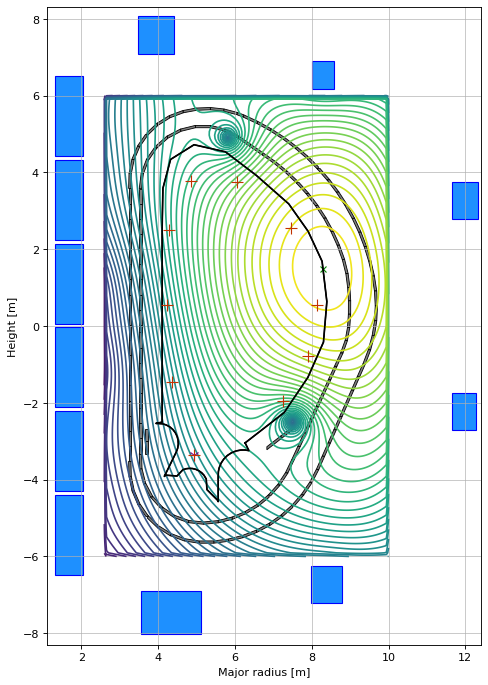

In [10]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 15), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax1,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax1, show=False)                                                          # plots the contraints
ax1.set_xlim(1.1, 12.4)
ax1.set_ylim(-8.3, 8.3)


In [11]:
eq.tokamak.getCurrents()

# # save coil currents to file
# import pickle
# with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
#     pickle.dump(obj=inverse_current_values, file=f)

{'CS1': -2785253.882990654,
 'CS2': 618128.1204290843,
 'CS3': 1230954.603418993,
 'VS3': -248837.09626092992,
 'PF1': 2095850.2036094572,
 'PF2': -416815.2447461601,
 'PF3': -377316.3371157291,
 'PF4': -84213.80603904695,
 'PF5': -182455.78480965085,
 'PF6': 244553.50641455542,
 'I1_0': 0.0,
 'I2_0': 0.0,
 'I3_0': 0.0,
 'I4_0': 0.0,
 'I5_0': 0.0,
 'I6_0': 0.0,
 'I7_0': 0.0,
 'I8_0': 0.0,
 'I9_0': 0.0,
 'I10_0': 0.0,
 'I11_0': 0.0,
 'I12_0': 0.0,
 'I13_0': 0.0,
 'I14_0': 0.0,
 'I15_0': 0.0,
 'I16_0': 0.0,
 'I17_0': 0.0,
 'I18_0': 0.0,
 'I19_0': 0.0,
 'I20_0': 0.0,
 'I21_0': 0.0,
 'I22_0': 0.0,
 'I23_0': 0.0,
 'I24_0': 0.0,
 'I25_0': 0.0,
 'I26_0': 0.0,
 'I27_0': 0.0,
 'I28_0': 0.0,
 'I29_0': 0.0,
 'I30_0': 0.0,
 'I31_0': 0.0,
 'I32_0': 0.0,
 'I33_0': 0.0,
 'I34_0': 0.0,
 'I35_0': 0.0,
 'I36_0': 0.0,
 'I37_0': 0.0,
 'I38_0': 0.0,
 'I39_0': 0.0,
 'I40_0': 0.0,
 'I41_0': 0.0,
 'I42_0': 0.0,
 'I43_0': 0.0,
 'I44_0': 0.0,
 'I45_0': 0.0,
 'I46_0': 0.0,
 'I47_0': 0.0,
 'I48_0': 0.0,
 'I49_0':